In [39]:
# Import all the libraries and dependencies required
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten, GRU, Bidirectional

from minisom import MiniSom

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

%matplotlib inline


# Dataset


### Read the dataset

In [40]:
# Reading data from csv and storing it into a dataframe
df = pd.read_csv('./Binance_ETHUSDT_day.csv')
df.head()

,Unix,Date,Symbol,Open,High,Low,Close,Volume ETH,Volume USDT,tradecount
0,1681689600000,2023-04-17,ETHUSDT,2118.66,2120.51,2056.25,2074.00,426972.7071,8.894333e+08,674817
1,1681603200000,2023-04-16,ETHUSDT,2090.61,2141.54,2072.72,2118.67,319880.4393,6.730346e+08,529231
2,1681516800000,2023-04-15,ETHUSDT,2099.99,2111.85,2071.13,2090.60,321823.7851,6.742609e+08,505299
3,1681430400000,2023-04-14,ETHUSDT,2012.00,2128.76,2009.22,2099.99,896307.3934,1.877720e+09,1182309
4,1681257600000,2023-04-12,ETHUSDT,1889.86,1933.00,1852.65,1917.39,630844.4186,1.195664e+09,801456


In [41]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2069 entries, 0 to 2068
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unix         2069 non-null   int64  
 1   Date         2069 non-null   object 
 2   Symbol       2069 non-null   object 
 3   Open         2069 non-null   float64
 4   High         2069 non-null   float64
 5   Low          2069 non-null   float64
 6   Close        2069 non-null   float64
 7   Volume ETH   2069 non-null   float64
 8   Volume USDT  2069 non-null   float64
 9   tradecount   2069 non-null   int64  
dtypes: float64(6), int64(2), object(2)
memory usage: 161.8+ KB


(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 [Text(-500.0, 0, '2018-12-29'),
  Text(0.0, 0, '2023-04-17'),
  Text(500.0, 0, '2021-12-02'),
  Text(1000.0, 0, '2020-07-20'),
  Text(1500.0, 0, '2019-03-08'),
  Text(2000.0, 0, '2017-10-24'),
  Text(2500.0, 0, '')])

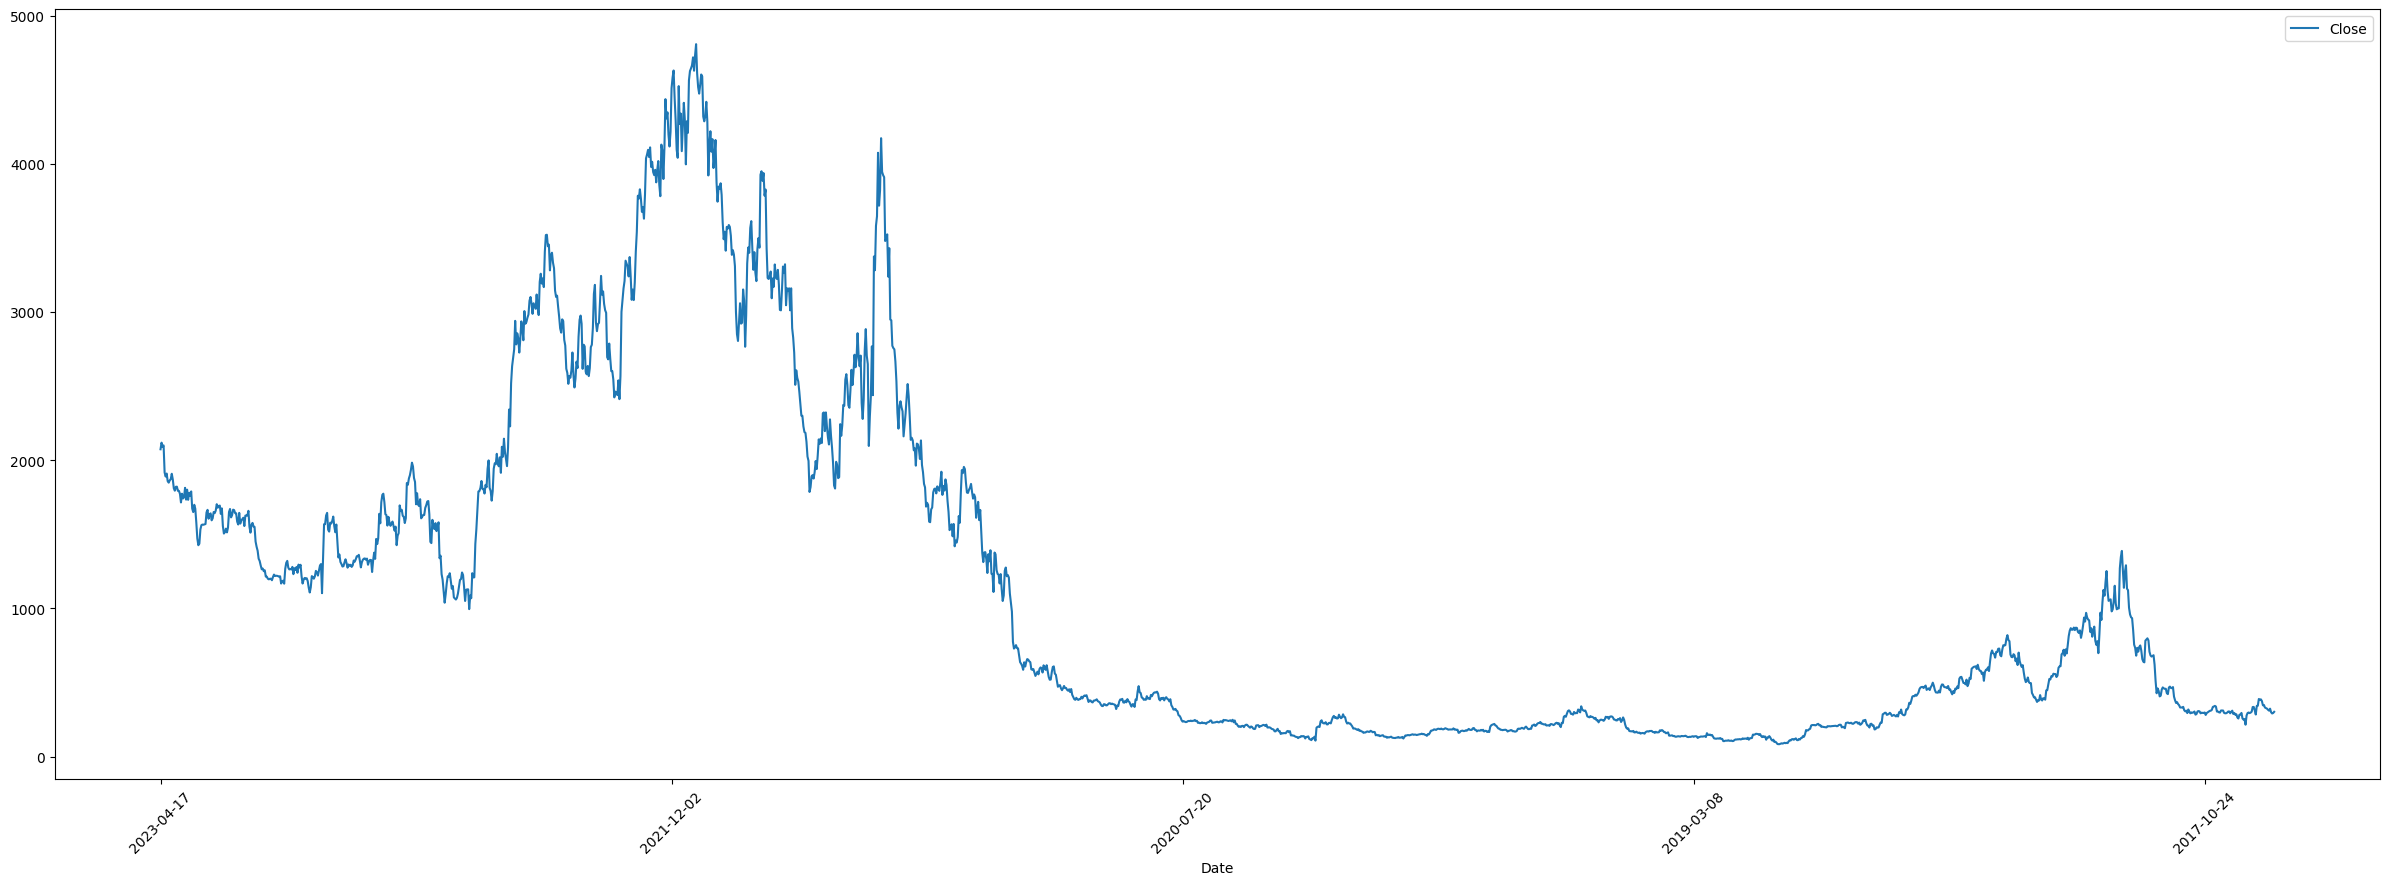

In [42]:
# Filter DataFrame to include rows from 2021 onwards
df_2021_to_2023 = df[df['Date'] >= '2017']
# Plot Ethereum prices from 2021 to 2023
df_2021_to_2023.plot('Date', 'Close', figsize=(30, 10))
plt.xticks(rotation=45)


In [43]:
print(df[df['Date'] >= '2023-01-01'])


              Unix        Date   Symbol     Open     High      Low    Close  \
0    1681689600000  2023-04-17  ETHUSDT  2118.66  2120.51  2056.25  2074.00   
1    1681603200000  2023-04-16  ETHUSDT  2090.61  2141.54  2072.72  2118.67   
2    1681516800000  2023-04-15  ETHUSDT  2099.99  2111.85  2071.13  2090.60   
3    1681430400000  2023-04-14  ETHUSDT  2012.00  2128.76  2009.22  2099.99   
4    1681257600000  2023-04-12  ETHUSDT  1889.86  1933.00  1852.65  1917.39   
..             ...         ...      ...      ...      ...      ...      ...   
101  1672876800000  2023-01-05  ETHUSDT  1256.91  1259.95  1242.81  1251.24   
102  1672790400000  2023-01-04  ETHUSDT  1214.56  1272.60  1212.71  1256.90   
103  1672704000000  2023-01-03  ETHUSDT  1213.99  1219.89  1204.93  1214.55   
104  1672617600000  2023-01-02  ETHUSDT  1200.33  1224.29  1193.00  1214.00   
105  1672531200000  2023-01-01  ETHUSDT  1196.13  1204.67  1190.57  1200.34   

      Volume ETH   Volume USDT  tradecount  
0    4

### Data preparing and Visualizing Data


In [44]:
# Sorting values to get old ones first and we predict the latest ones
df.sort_values("Date", axis=0, ascending=True, inplace=True)
df.head()

,Unix,Date,Symbol,Open,High,Low,Close,Volume ETH,Volume USDT,tradecount
2068,1502928000000,2017-08-17,ETHUSDT,301.13,312.18,298.00,302.00,7030.71034,2.154655e+06,4522
2067,1503014400000,2017-08-18,ETHUSDT,302.00,311.79,283.94,293.96,9537.84646,2.858947e+06,5658
2066,1503100800000,2017-08-19,ETHUSDT,293.31,299.90,278.00,290.91,2146.19773,6.200226e+05,1795
2065,1503187200000,2017-08-20,ETHUSDT,289.41,300.53,282.85,299.10,2510.13871,7.428479e+05,2038
2064,1503273600000,2017-08-21,ETHUSDT,299.10,346.52,294.60,323.29,5219.44542,1.689472e+06,3925


C:\Users\ACER\AppData\Local\Temp\ipykernel_21148\1315889647.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


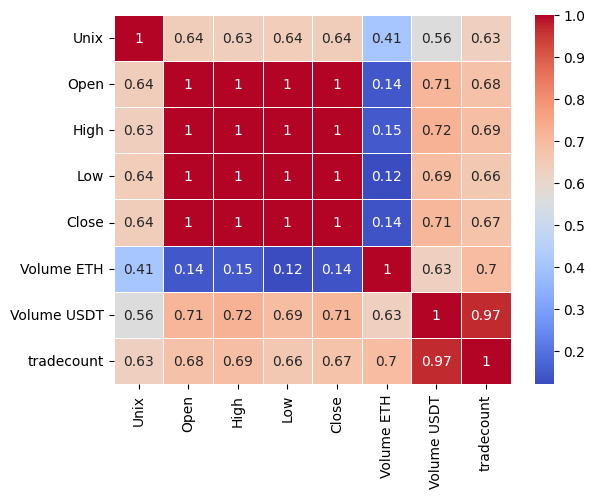

In [45]:
# Plot correlation matrix
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, linewidths=0.5)
plt.show()


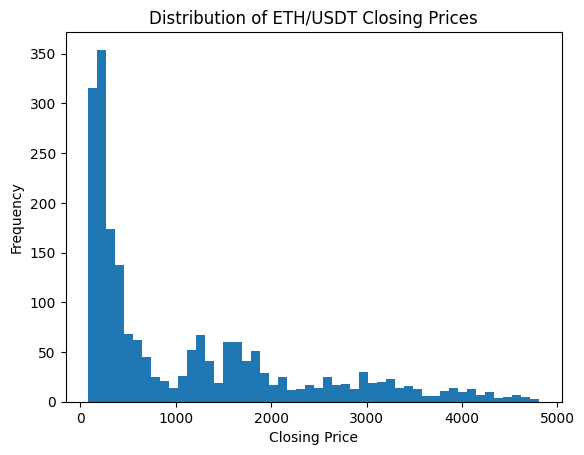

In [46]:
# Plot histogram of closing prices
plt.hist(df['Close'], bins=50)
plt.title('Distribution of ETH/USDT Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()

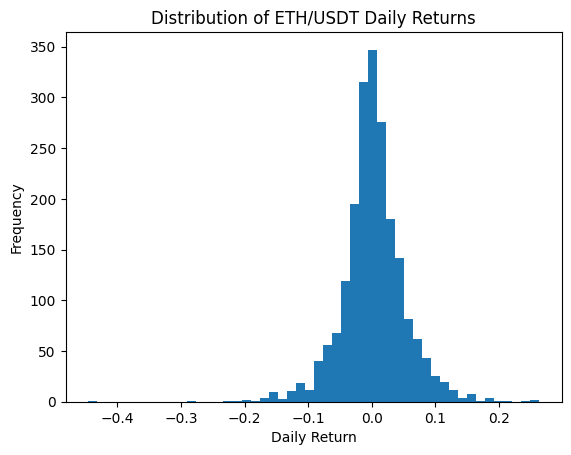

In [47]:
df['daily_return'] = df['Close'].pct_change()

# Plot histogram of daily returns
plt.hist(df['daily_return'].dropna(), bins=50)
plt.title('Distribution of ETH/USDT Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()


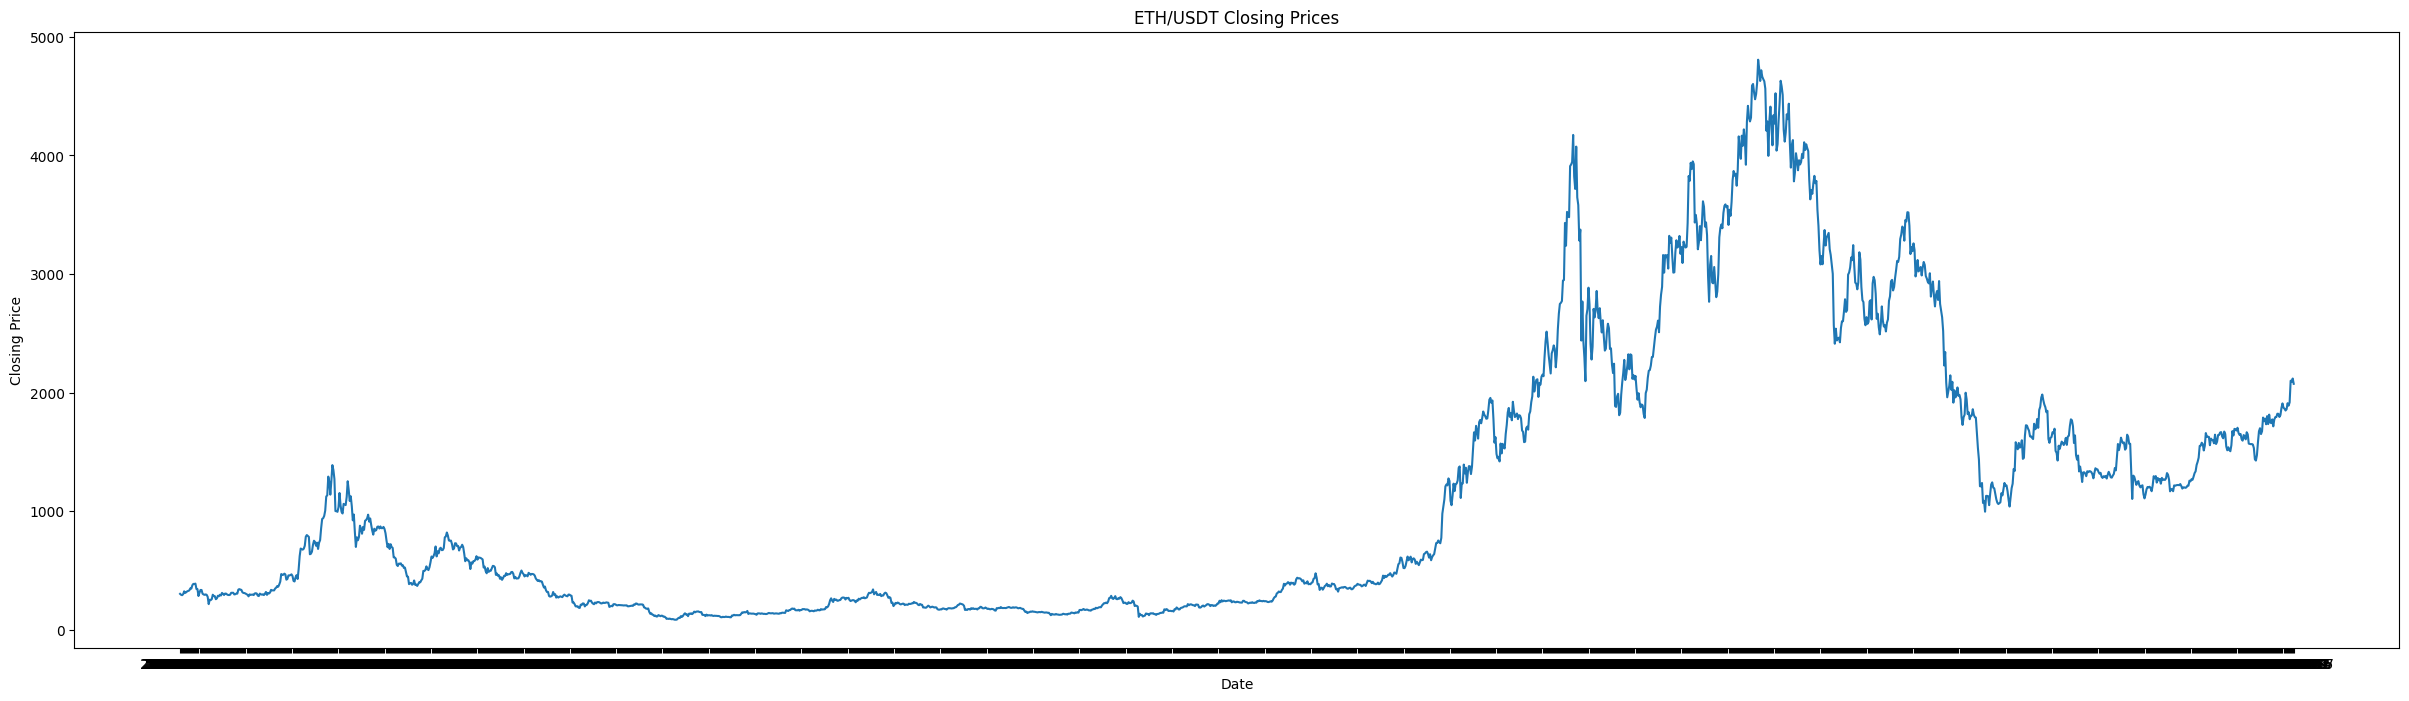

In [48]:
# Plot closing prices over time
plt.figure(figsize=(30, 8))
plt.plot(df['Date'], df['Close'])
plt.title('ETH/USDT Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()


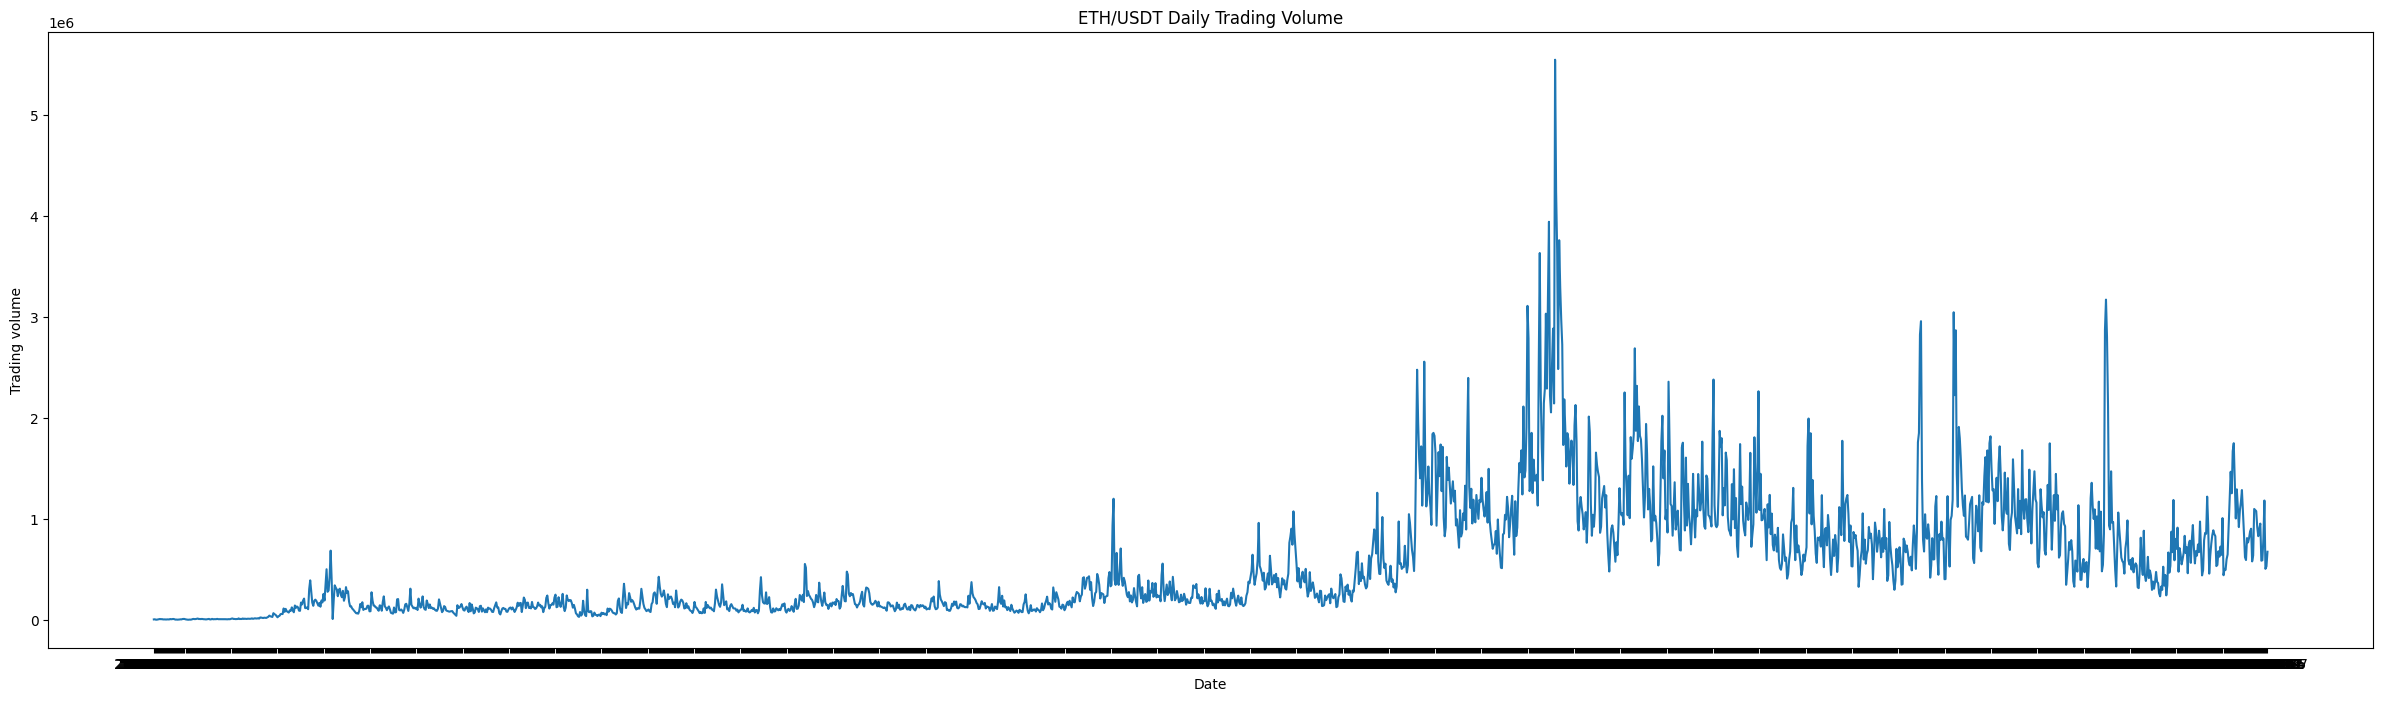

In [49]:
# Plot tradecount over time
plt.figure(figsize=(30, 8))
plt.plot(df['Date'], df['tradecount'])
plt.xlabel('Date')
plt.ylabel('Trading volume')
plt.title('ETH/USDT Daily Trading Volume')
plt.show()

In [50]:
# We have almost 3 years of data and 11 columns
df.shape

(2069, 11)

In [51]:
df['Date'] = pd.to_datetime(df['Date'])
# Set the 'Date' column as the DataFrame index
df.set_index('Date', inplace=True)
# Resample the DataFrame to fill any missing dates
df = df.resample('D').ffill()


In [52]:
df.tail(6)

,Unix,Symbol,Open,High,Low,Close,Volume ETH,Volume USDT,tradecount,daily_return
Date,,,,,,,,,,
2023-04-12,1681257600000,ETHUSDT,1889.86,1933.00,1852.65,1917.39,630844.4186,1.195664e+09,801456,0.014567
2023-04-13,1681257600000,ETHUSDT,1889.86,1933.00,1852.65,1917.39,630844.4186,1.195664e+09,801456,0.014567
2023-04-14,1681430400000,ETHUSDT,2012.00,2128.76,2009.22,2099.99,896307.3934,1.877720e+09,1182309,0.095234
2023-04-15,1681516800000,ETHUSDT,2099.99,2111.85,2071.13,2090.60,321823.7851,6.742609e+08,505299,-0.004471
2023-04-16,1681603200000,ETHUSDT,2090.61,2141.54,2072.72,2118.67,319880.4393,6.730346e+08,529231,0.013427
2023-04-17,1681689600000,ETHUSDT,2118.66,2120.51,2056.25,2074.00,426972.7071,8.894333e+08,674817,-0.021084


In [53]:
df.shape

(2070, 10)

In [54]:
# Dropping columns which are not required in analysis
df.drop(['Unix', 'Symbol', 'tradecount', 'daily_return'], axis=1, inplace=True)
df.head()

,Open,High,Low,Close,Volume ETH,Volume USDT
Date,,,,,,
2017-08-17,301.13,312.18,298.00,302.00,7030.71034,2.154655e+06
2017-08-18,302.00,311.79,283.94,293.96,9537.84646,2.858947e+06
2017-08-19,293.31,299.90,278.00,290.91,2146.19773,6.200226e+05
2017-08-20,289.41,300.53,282.85,299.10,2510.13871,7.428479e+05
2017-08-21,299.10,346.52,294.60,323.29,5219.44542,1.689472e+06


## Data processing

In [55]:
# The length of the dataframe
print(len(df))

2070


##### For LSTM Model, Random Forest Model, SVR Model

- We build little data frames consisting of 10 consecutive days of data called windows

In [56]:
data = df.iloc[:, 3]
windows = []
target = []
length = 10
for i in range(len(data)-length):
    x = data[i:i+length]
    y = data[i+length]
    windows.append(x)
    target.append(y)


In [57]:

windows = np.array(windows)
target = np.array(target)
target = target.reshape(-1, 1)
windows.shape, target.shape


((2060, 10), (2060, 1))

- Scaling data into a specific range 

In [58]:
sc = MinMaxScaler()
windows_scaled = sc.fit_transform(windows)
target_scaled = sc.fit_transform(target)


In [59]:
windows_scaled = windows_scaled.reshape((len(windows_scaled), length, 1))
windows_scaled.shape


(2060, 10, 1)

- Next, I split the data into two sets — training set and test set with 80% and 20% data respectively.

In [60]:
num_train = int(0.80 * windows_scaled.shape[0])

X_train = windows_scaled[:num_train, :, :]
X_test = windows_scaled[num_train:, :, :]
y_train = target_scaled[:num_train, :]
y_test = target_scaled[num_train:, :]


In [61]:

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((1648, 10, 1), (412, 10, 1), (1648, 1), (412, 1))

- Here's a plot of Ethereum prices from 2017 to 2023 (Divided in training and testing set)

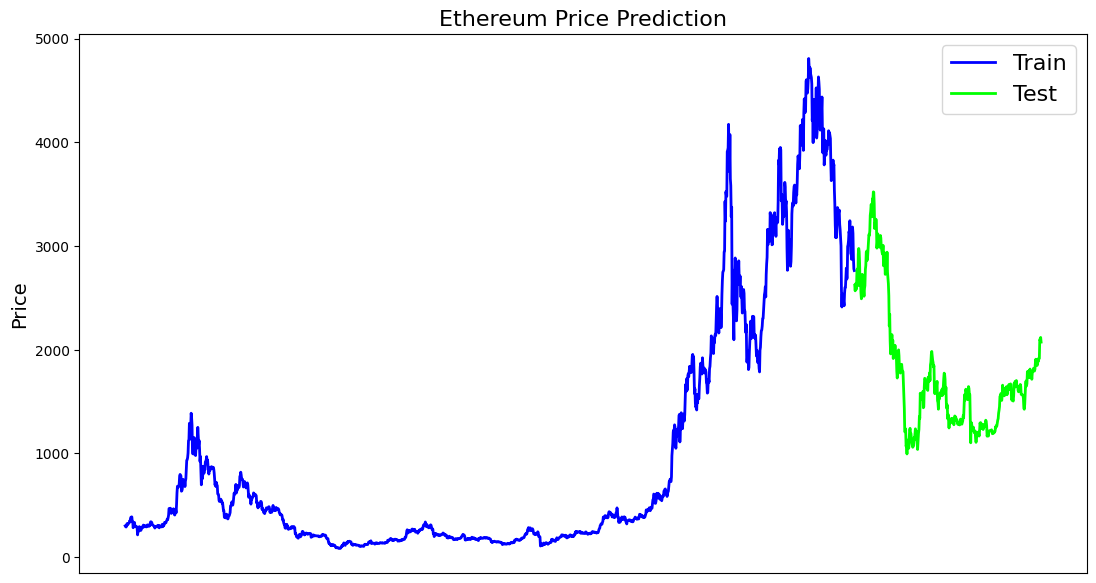

In [62]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(df.iloc[:num_train, 3],color = 'blue', label="Train", linewidth=2)
ax.plot(df.iloc[num_train:, 3],color = 'lime', label="Test", linewidth=2)
ax.set_ylabel('Price', fontsize=14)
ax.set_title('Ethereum Price Prediction', fontsize=16)
ax.get_xaxis().set_visible(False)
ax.legend(loc='best', fontsize=16)

##### For XGBoost Model

- Create data matrices that can be used for training and testing the XGBoost model.

In [63]:
# Creating XGBoost train and test data
dtrain = xgb.DMatrix(X_train.reshape(X_train.shape[0], -1), label=y_train)
dtest = xgb.DMatrix(X_test.reshape(X_test.shape[0], -1), label=y_test)


# Models building

### MLP Model


In [64]:
def build_mlp_model(input_dim, activ_func, loss, optimizer):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation=activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model


In [65]:
activ_func = 'linear'
loss = 'mse'
optimizer = 'adam'
input_dim = X_train.shape[1]
batch_size = 512
epochs = 30

In [66]:
# Instantiate the MLP model
mlp_model = build_mlp_model(input_dim=input_dim, activ_func=activ_func, loss=loss, optimizer=optimizer)

# Train the MLP model
out = mlp_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.1)


Epoch 1/30


3/3 [==============================] - 1s 88ms/step - loss: 0.0196 - val_loss: 0.0274
Epoch 2/30
3/3 [==============================] - 0s 22ms/step - loss: 0.0054 - val_loss: 0.0179
Epoch 3/30
3/3 [==============================] - 0s 20ms/step - loss: 0.0075 - val_loss: 0.0311
Epoch 4/30
3/3 [==============================] - 0s 23ms/step - loss: 0.0056 - val_loss: 0.0108
Epoch 5/30
3/3 [==============================] - 0s 20ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 6/30
3/3 [==============================] - 0s 24ms/step - loss: 0.0034 - val_loss: 0.0106
Epoch 7/30
3/3 [==============================] - 0s 16ms/step - loss: 0.0047 - val_loss: 0.0141
Epoch 8/30
3/3 [==============================] - 0s 20ms/step - loss: 0.0037 - val_loss: 0.0090
Epoch 9/30
3/3 [==============================] - 0s 24ms/step - loss: 0.0029 - val_loss: 0.0039
Epoch 10/30
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 11/30
3/3 [=======================

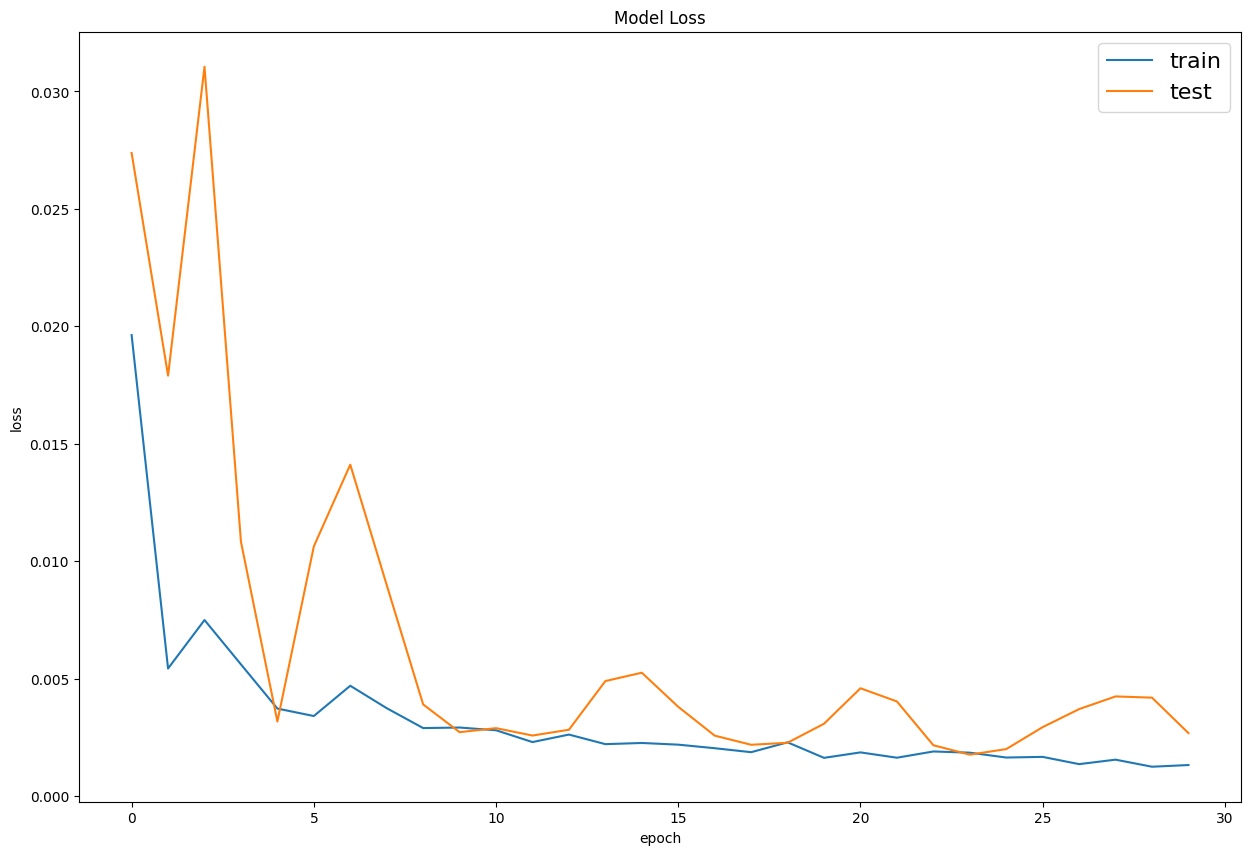

In [67]:
# Let's visualize how loss changes as number of epochs increases
plt.figure(figsize=(15, 10))
plt.plot(out.history['loss'])
plt.plot(out.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best', fontsize=16)
plt.show()


### GRU Model


In [68]:
def build_gru_model(input_shape, output_size, units, activ_func, loss, optimizer):
    model = Sequential()
    model.add(GRU(units=units, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(GRU(units=units))
    model.add(Dropout(0.1))
    model.add(Dense(units=output_size, activation=activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model


In [69]:
input_shape = (10, 1)
output_size = 1  
units = 32  
activ_func = 'linear'  
loss = 'mse' 
optimizer = 'adam'  
batch_size = 512
epochs = 30


In [70]:
# Build the GRU model
gru_model = build_gru_model(input_shape=input_shape, output_size=output_size, units=units,
                            activ_func=activ_func, loss=loss, optimizer=optimizer)

# Train the GRU model using X_train and y_train
out = gru_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              verbose=1, validation_split=0.1)


Epoch 1/30
3/3 [==============================] - 5s 375ms/step - loss: 0.0458 - val_loss: 0.3941
Epoch 2/30
3/3 [==============================] - 0s 25ms/step - loss: 0.0243 - val_loss: 0.2021
Epoch 3/30
3/3 [==============================] - 0s 25ms/step - loss: 0.0161 - val_loss: 0.0885
Epoch 4/30
3/3 [==============================] - 0s 25ms/step - loss: 0.0125 - val_loss: 0.0396
Epoch 5/30
3/3 [==============================] - 0s 25ms/step - loss: 0.0092 - val_loss: 0.0220
Epoch 6/30
3/3 [==============================] - 0s 27ms/step - loss: 0.0048 - val_loss: 0.0144
Epoch 7/30
3/3 [==============================] - 0s 26ms/step - loss: 0.0021 - val_loss: 0.0087
Epoch 8/30
3/3 [==============================] - 0s 26ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 9/30
3/3 [==============================] - 0s 25ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 10/30
3/3 [==============================] - 0s 26ms/step - loss: 0.0015 - val_loss: 0.0096
Epoch 11/30
3/3 [===========

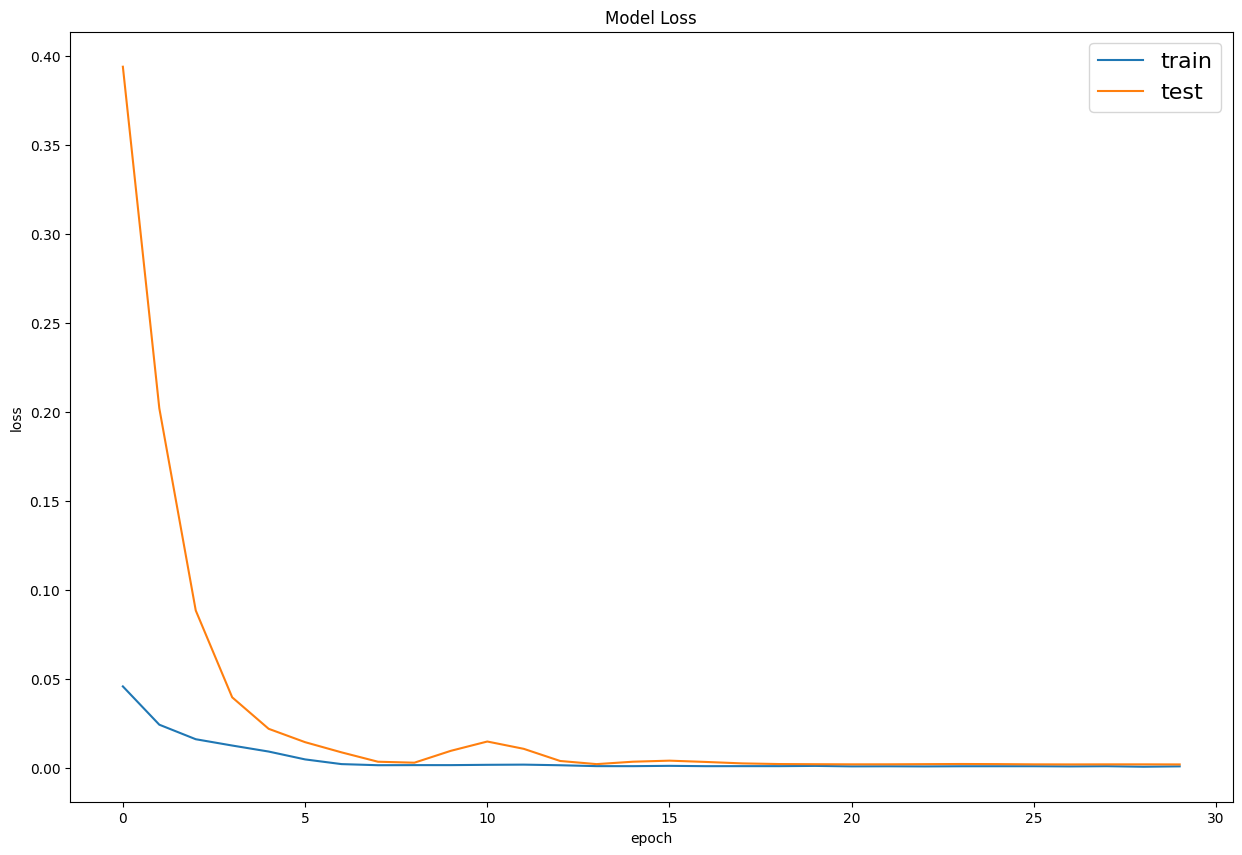

In [71]:
# Let's visualize how loss changes as number of epochs increases
plt.figure(figsize=(15, 10))
plt.plot(out.history['loss'])
plt.plot(out.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best', fontsize=16)
plt.show()


### CNN Model

In [116]:
def build_cnn_model(input_shape, output_size, filters, kernel_size, pool_size, activ_func, loss, optimizer):
    model = Sequential()
    model.add(Conv1D(filters, kernel_size, activation=activ_func, input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(units=output_size, activation=activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model


In [117]:
activ_func = 'linear'
loss = 'mse'
optimizer = 'adam'
input_shape = (10, 1)
filters = 32
kernel_size = 3
pool_size = 2
batch_size = 512
epochs = 30

In [118]:
cnn_model = build_cnn_model(input_shape=input_shape, output_size=1, filters=filters,
                            kernel_size = kernel_size, pool_size = pool_size, activ_func = activ_func, loss = loss, optimizer = optimizer)
out = cnn_model.fit(X_train, y_train, epochs=epochs,
                     batch_size=batch_size, verbose=1, validation_split=0.1)


Epoch 1/30
3/3 [==============================] - 1s 133ms/step - loss: 0.0352 - val_loss: 0.3262
Epoch 2/30
3/3 [==============================] - 0s 21ms/step - loss: 0.0217 - val_loss: 0.2019
Epoch 3/30
3/3 [==============================] - 0s 16ms/step - loss: 0.0130 - val_loss: 0.1112
Epoch 4/30
3/3 [==============================] - 0s 19ms/step - loss: 0.0081 - val_loss: 0.0534
Epoch 5/30
3/3 [==============================] - 0s 15ms/step - loss: 0.0062 - val_loss: 0.0224
Epoch 6/30
3/3 [==============================] - 0s 16ms/step - loss: 0.0055 - val_loss: 0.0089
Epoch 7/30
3/3 [==============================] - 0s 16ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 8/30
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 9/30
3/3 [==============================] - 0s 23ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 10/30
3/3 [==============================] - 0s 19ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 11/30
3/3 [===========

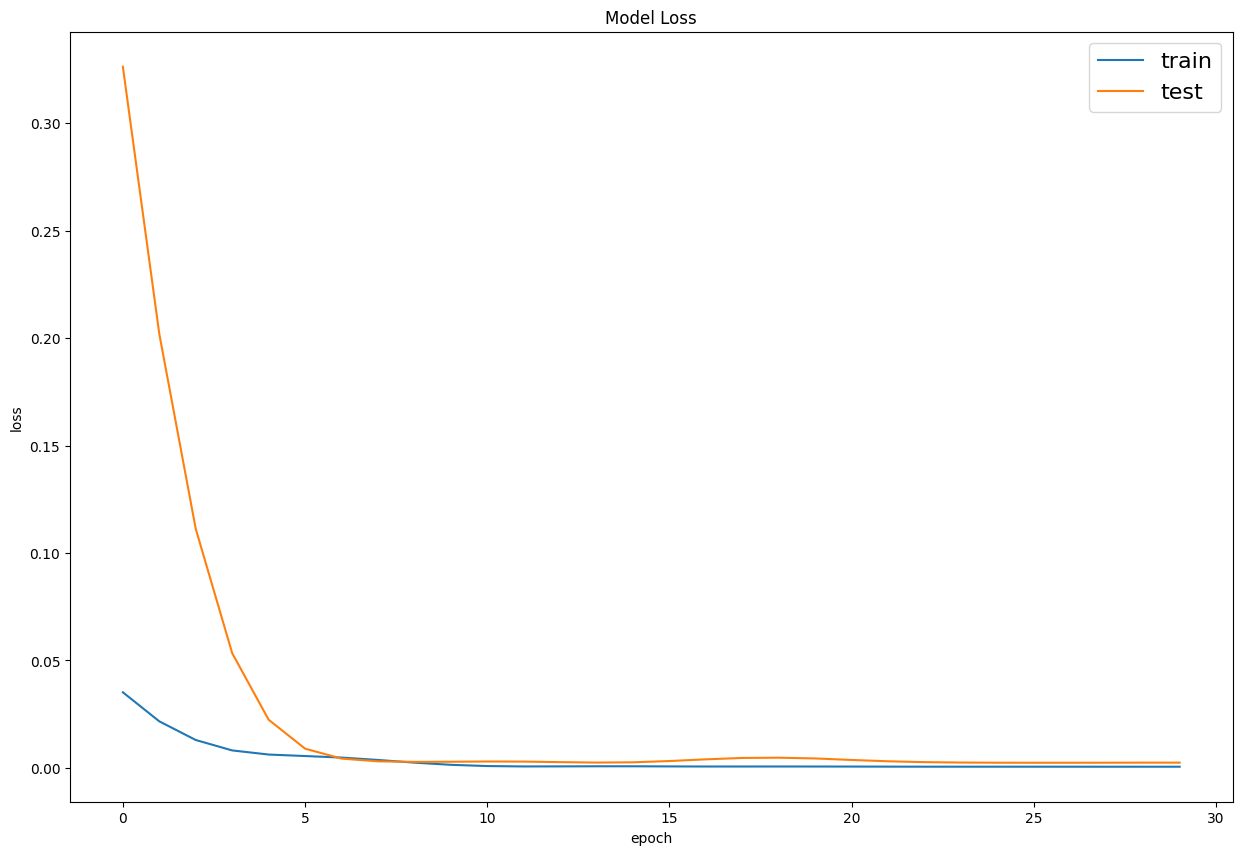

In [119]:
# Let's visualize how loss changes as number of epochs increases
plt.figure(figsize=(15, 10))
plt.plot(out.history['loss'])
plt.plot(out.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best', fontsize=16)
plt.show()


### LSTM Model

In [76]:
def build_lstm_model(input_data, output_size, neurons, activ_func, dropout, loss, optimizer):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(
        input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [77]:
lstm_neurons = 100
activ_func = 'linear'
dropout = 0.2
loss = 'mse'
optimizer = 'adam'

batch_size = 512
epochs = 30

In [78]:
lstm_model = build_lstm_model(X_train, output_size = 1, neurons=lstm_neurons, activ_func=activ_func, dropout=dropout, loss=loss, optimizer=optimizer)
out = lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.1)

Epoch 1/30
3/3 [==============================] - 3s 241ms/step - loss: 0.0351 - val_loss: 0.2613
Epoch 2/30
3/3 [==============================] - 0s 31ms/step - loss: 0.0151 - val_loss: 0.0843
Epoch 3/30
3/3 [==============================] - 0s 31ms/step - loss: 0.0069 - val_loss: 0.0076
Epoch 4/30
3/3 [==============================] - 0s 31ms/step - loss: 0.0066 - val_loss: 0.0052
Epoch 5/30
3/3 [==============================] - 0s 33ms/step - loss: 0.0047 - val_loss: 0.0039
Epoch 6/30
3/3 [==============================] - 0s 31ms/step - loss: 0.0018 - val_loss: 0.0036
Epoch 7/30
3/3 [==============================] - 0s 31ms/step - loss: 0.0014 - val_loss: 0.0058
Epoch 8/30
3/3 [==============================] - 0s 31ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 9/30
3/3 [==============================] - 0s 31ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 10/30
3/3 [==============================] - 0s 30ms/step - loss: 0.0015 - val_loss: 0.0111
Epoch 11/30
3/3 [===========

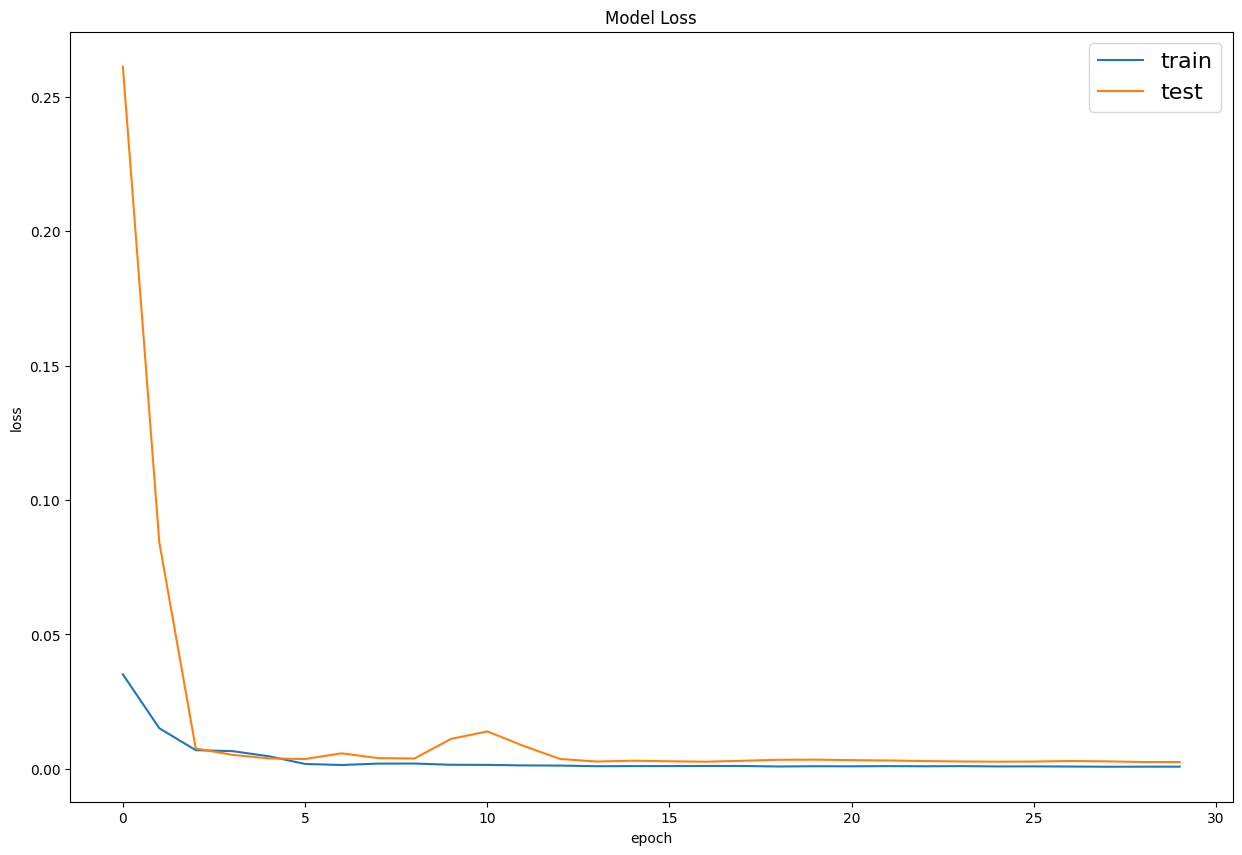

In [79]:
# Let's visualize how loss changes as number of epochs increases
plt.figure(figsize=(15, 10))
plt.plot(out.history['loss'])
plt.plot(out.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best', fontsize=16)
plt.show()

### BI-LSTM Model


In [80]:
def build_bilstm_model(input_data, output_size, neurons, activ_func, dropout, loss, optimizer):
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, input_shape=(
        input_data.shape[1], input_data.shape[2]))))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model


In [81]:
lstm_neurons = 100
activ_func = 'linear'
dropout = 0.2
loss = 'mse'
optimizer = 'adam'
batch_size = 512
epochs = 30

In [82]:
bilstm_model = build_bilstm_model(X_train, output_size=1, neurons=lstm_neurons,
                                  activ_func=activ_func, dropout=dropout, loss=loss, optimizer=optimizer)
out = bilstm_model.fit(X_train, y_train, epochs=epochs,
                       batch_size=batch_size, verbose=1, validation_split=0.1)


Epoch 1/30
3/3 [==============================] - 5s 562ms/step - loss: 0.0324 - val_loss: 0.1788
Epoch 2/30
3/3 [==============================] - 0s 62ms/step - loss: 0.0102 - val_loss: 0.0163
Epoch 3/30
3/3 [==============================] - 0s 50ms/step - loss: 0.0071 - val_loss: 0.0084
Epoch 4/30
3/3 [==============================] - 0s 59ms/step - loss: 0.0059 - val_loss: 0.0076
Epoch 5/30
3/3 [==============================] - 0s 51ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 6/30
3/3 [==============================] - 0s 51ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 7/30
3/3 [==============================] - 0s 52ms/step - loss: 0.0021 - val_loss: 0.0042
Epoch 8/30
3/3 [==============================] - 0s 52ms/step - loss: 0.0021 - val_loss: 0.0036
Epoch 9/30
3/3 [==============================] - 0s 50ms/step - loss: 0.0017 - val_loss: 0.0083
Epoch 10/30
3/3 [==============================] - 0s 52ms/step - loss: 0.0013 - val_loss: 0.0128
Epoch 11/30
3/3 [===========

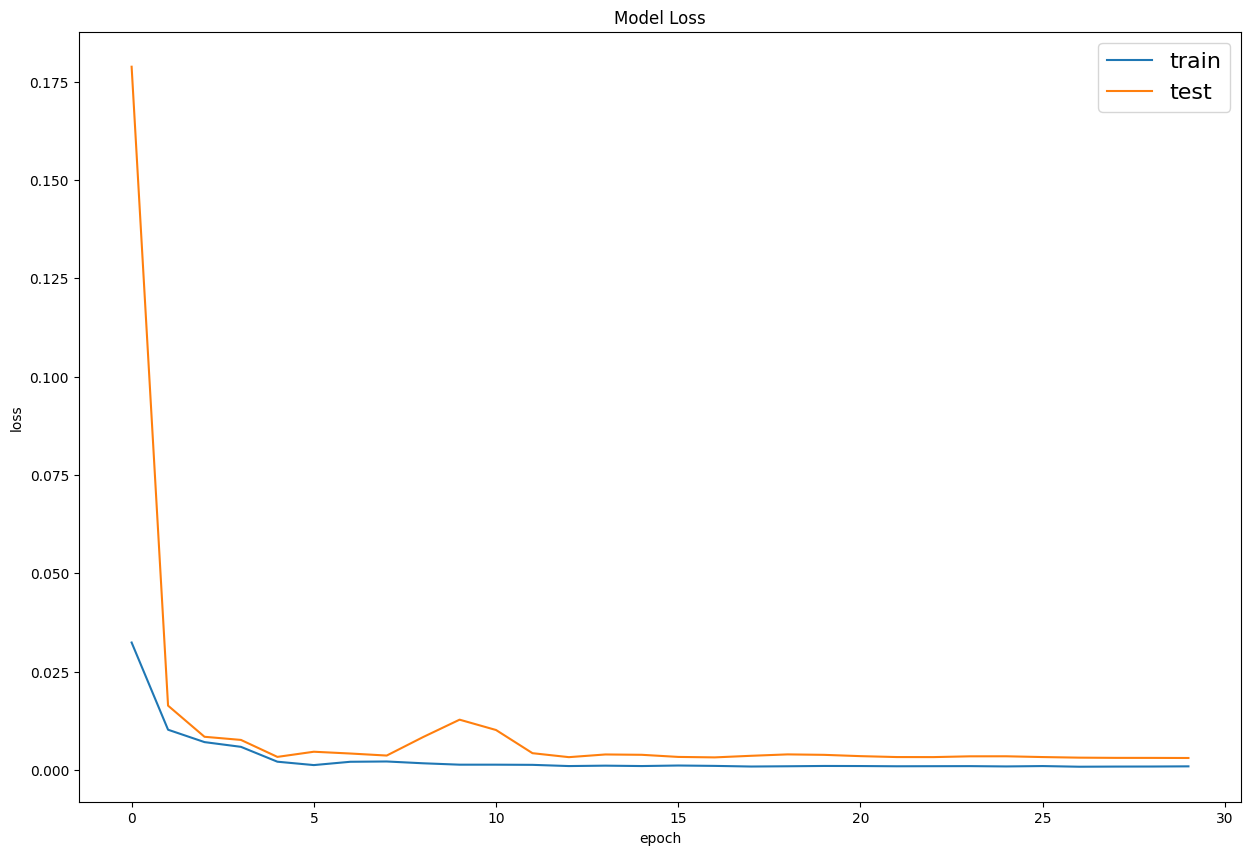

In [83]:
# Let's visualize how loss changes as number of epochs increases
plt.figure(figsize=(15, 10))
plt.plot(out.history['loss'])
plt.plot(out.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best', fontsize=16)
plt.show()


### XGBoost Model


In [84]:
# Defining hyperparameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.05,
    'max_depth': 4,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'verbosity': 0
}


In [85]:
# Training the XGBoost model
num_round = 1000
xgb_model = xgb.train(params, dtrain, num_round)

### Random Forest Model


In [86]:
# Creating a Random Forest Regressor object
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [87]:
# Fitting the model on training data
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

C:\Users\ACER\AppData\Local\Temp\ipykernel_21148\1127196900.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)


RandomForestRegressor(random_state=42)

### SVR Model

In [88]:
svr_model = SVR(kernel='linear', C=100, gamma='scale')
svr_model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1]), y_train.ravel())

SVR(C=100, kernel='linear')

# Testing Models


### MLP Model Testing


In [89]:
# Making predictions on test data
mlp_pred = mlp_model.predict(X_test)

# Inverting the scaling of the predictions and test data
mlp_pred_transformed = sc.inverse_transform(mlp_pred)
y_test_transformed = sc.inverse_transform(y_test)

13/13 [==============================] - 0s 750us/step


In [124]:
# Calculating the mean squared error of the LSTM model
mlp_mse = mean_squared_error(mlp_pred, y_test)
mlp_mae = mean_absolute_error(mlp_pred, y_test)
mlp_rmse = mean_squared_error(mlp_pred, y_test, squared=False)

print('MLP MSE:', mlp_mse)
print('MLP MAE:', mlp_mae)
print('MLP RMSE:', mlp_rmse)


MLP MSE: 0.0006500998699703938
MLP MAE: 0.02047678372714629
MLP RMSE: 0.025497056103997454


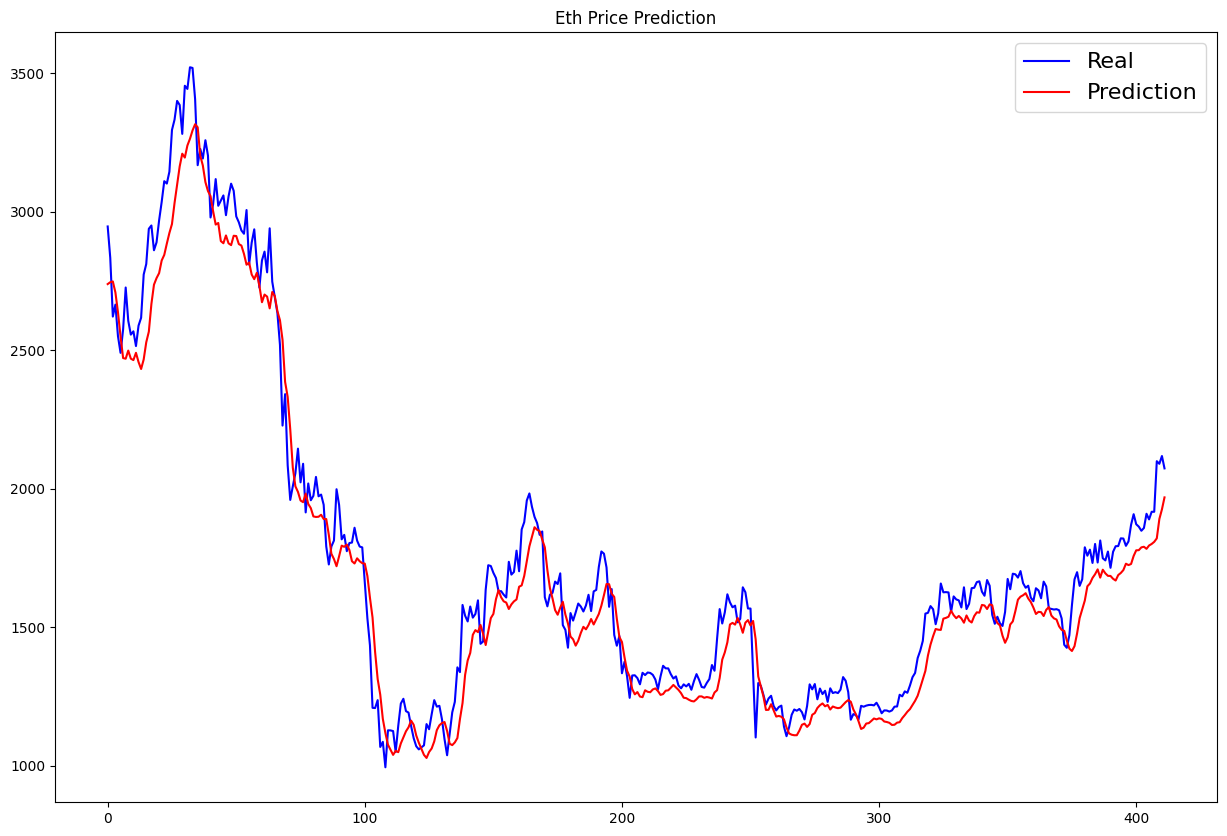

In [91]:
plt.figure(figsize=(15, 10))
plt.plot(y_test_transformed, color='blue', label='Real')
plt.plot(mlp_pred_transformed, color='red', label='Prediction')
plt.title('Eth Price Prediction')
plt.legend(loc='best', fontsize=16)
plt.show()


### GRU Model Testing


In [92]:
# Making predictions on test data
gru_pred = gru_model.predict(X_test)
# Inverting the scaling of the predictions and test data
gru_pred_transformed = sc.inverse_transform(gru_pred)
y_test_transformed = sc.inverse_transform(y_test)


13/13 [==============================] - 1s 2ms/step


In [125]:
# Calculating the mean squared error of the LSTM model
gru_mse = mean_squared_error(gru_pred, y_test)
gru_mae = mean_absolute_error(gru_pred, y_test)
gru_rmse = mean_squared_error(gru_pred, y_test, squared=False)

print('GRU MSE:', gru_mse)
print('GRU MAE:', gru_mae)
print('GRU RMSE:', gru_rmse)


GRU MSE: 0.0005600607069121045
GRU MAE: 0.016615089026171384
GRU RMSE: 0.0236656017652648


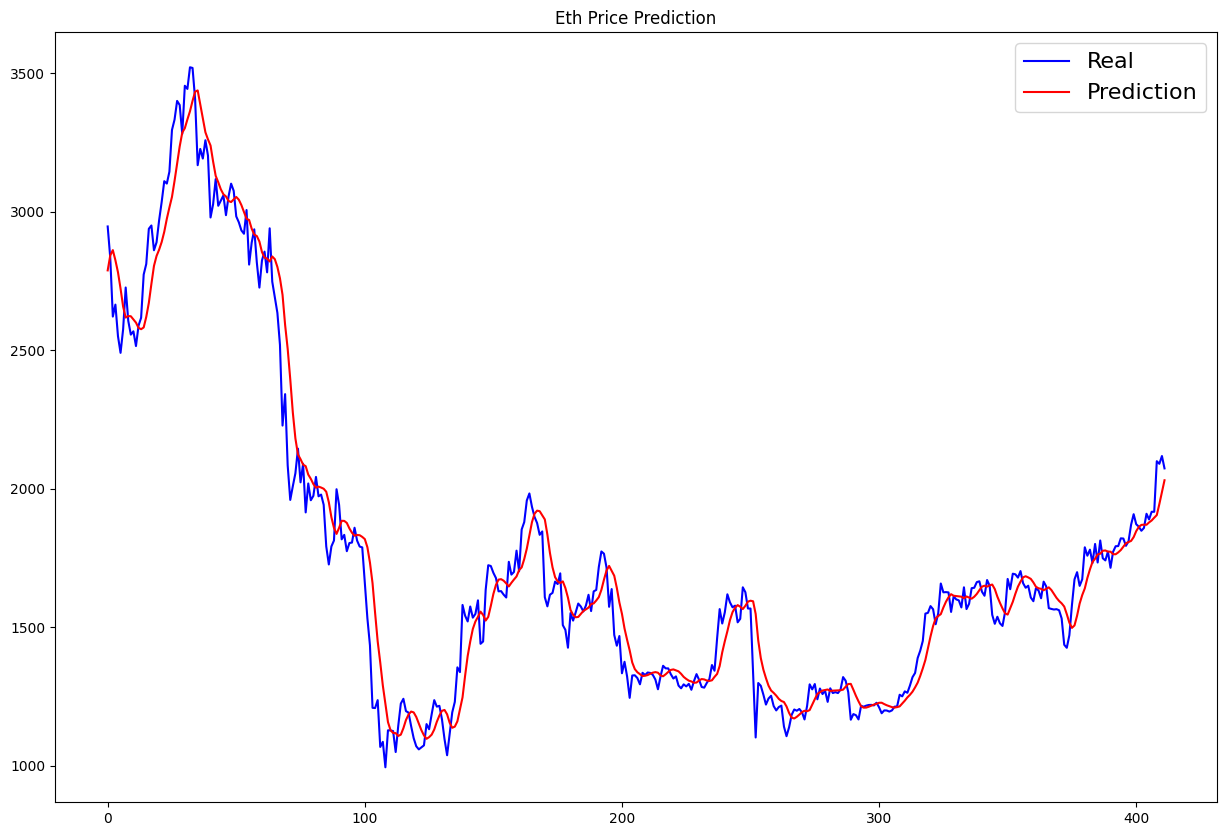

In [94]:
plt.figure(figsize=(15, 10))
plt.plot(y_test_transformed, color='blue', label='Real')
plt.plot(gru_pred_transformed, color='red', label='Prediction')
plt.title('Eth Price Prediction')
plt.legend(loc='best', fontsize=16)
plt.show()


### CNN Model Testing

In [120]:
# Making predictions on test data
cnn_pred = cnn_model.predict(X_test)
# Inverting the scaling of the predictions and test data
cnn_pred_transformed = sc.inverse_transform(cnn_pred)
y_test_transformed = sc.inverse_transform(y_test)


13/13 [==============================] - 0s 827us/step


In [131]:
# Calculating the mean squared error of the LSTM model
cnn_mse = mean_squared_error(cnn_pred, y_test)
cnn_mae = mean_absolute_error(cnn_pred, y_test)
cnn_rmse = mean_squared_error(cnn_pred, y_test, squared=False)

print('CNN MSE:', cnn_mse)
print('CNN MAE:', cnn_mae)
print('CNN RMSE:', cnn_rmse)


CNN MSE: 0.0007349888311022533
CNN MAE: 0.01913151473671763
CNN RMSE: 0.027110677437169536


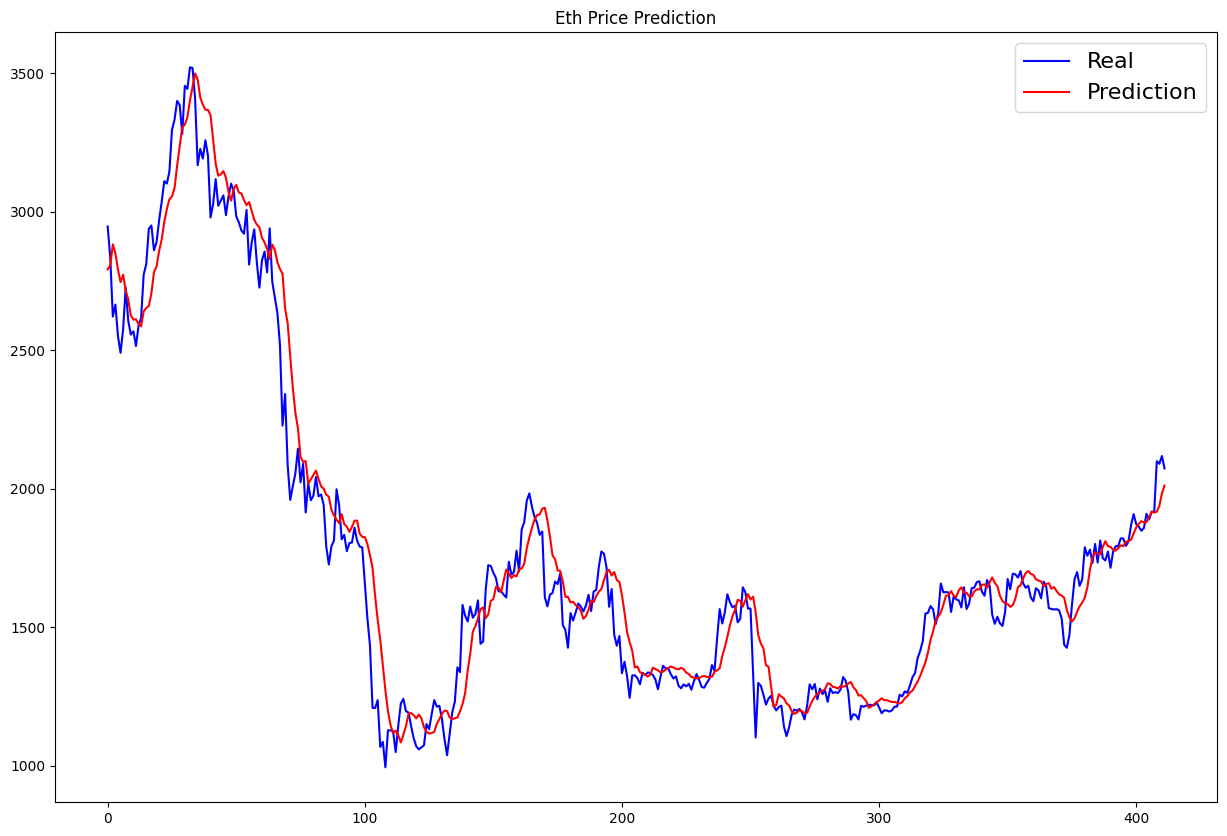

In [122]:
plt.figure(figsize=(15, 10))
plt.plot(y_test_transformed, color='blue', label='Real')
plt.plot(cnn_pred_transformed, color='red', label='Prediction')
plt.title('Eth Price Prediction')
plt.legend(loc='best', fontsize=16)
plt.show()


### LSTM Model Testing

In [98]:
# Making predictions on test data
lstm_pred = lstm_model.predict(X_test)
# Inverting the scaling of the predictions and test data
lstm_pred_transformed = sc.inverse_transform(lstm_pred)
y_test_transformed = sc.inverse_transform(y_test)


13/13 [==============================] - 0s 2ms/step


In [127]:
# Calculating the mean squared error of the LSTM model
lstm_mse = mean_squared_error(lstm_pred, y_test)
lstm_mae = mean_absolute_error(lstm_pred, y_test)
lstm_rmse = mean_squared_error(lstm_pred, y_test, squared = False)

print('LSTM MSE:', lstm_mse)
print('LSTM MAE:', lstm_mae)
print('LSTM RMSE:', lstm_rmse)


LSTM MSE: 0.0007881370827928452
LSTM MAE: 0.020473051942627708
LSTM RMSE: 0.028073779275203496


- Plotting the figure of Th Actual Value vs The Prediction Value 

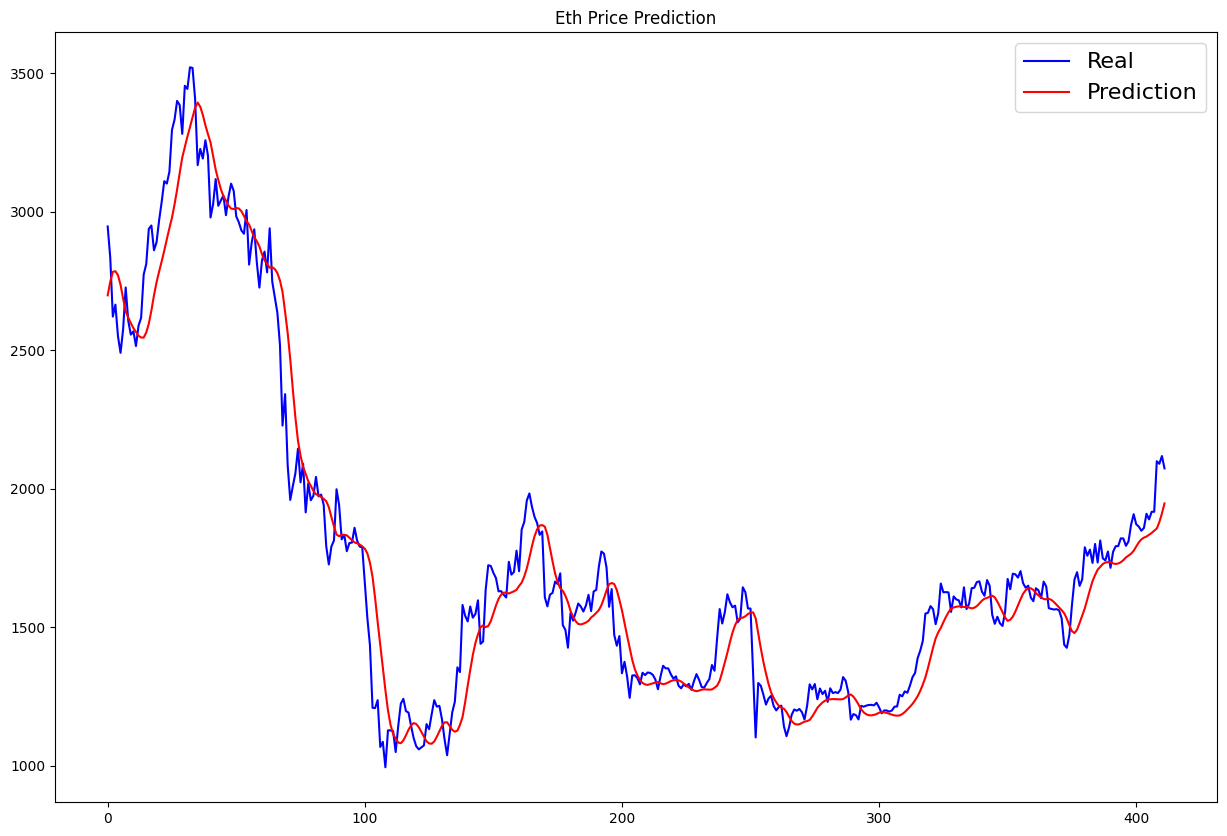

In [100]:
plt.figure(figsize=(15, 10))
plt.plot(y_test_transformed, color='blue', label='Real')
plt.plot(lstm_pred_transformed, color='red', label='Prediction')
plt.title('Eth Price Prediction')
plt.legend(loc='best', fontsize=16)
plt.show()


### BI-LSTM Model Testing

In [101]:
# Making predictions on test data
bilstm_pred = bilstm_model.predict(X_test)
# Inverting the scaling of the predictions and test data
bilstm_pred_transformed = sc.inverse_transform(bilstm_pred)
y_test_transformed = sc.inverse_transform(y_test)


13/13 [==============================] - 1s 2ms/step


In [128]:
# Calculating the mean squared error of the LSTM model
bilstm_mse = mean_squared_error(bilstm_pred, y_test)
bilstm_mae = mean_absolute_error(bilstm_pred, y_test)
bilstm_rmse = mean_squared_error(bilstm_pred, y_test, squared=False)

print('BI-LSTM MSE:', bilstm_mse)
print('BI-LSTM MAE:', bilstm_mae)
print('BI-LSTM RMSE:', bilstm_rmse)


BI-LSTM MSE: 0.0009980063750317978
BI-LSTM MAE: 0.022464854164516372
BI-LSTM RMSE: 0.031591238896754234


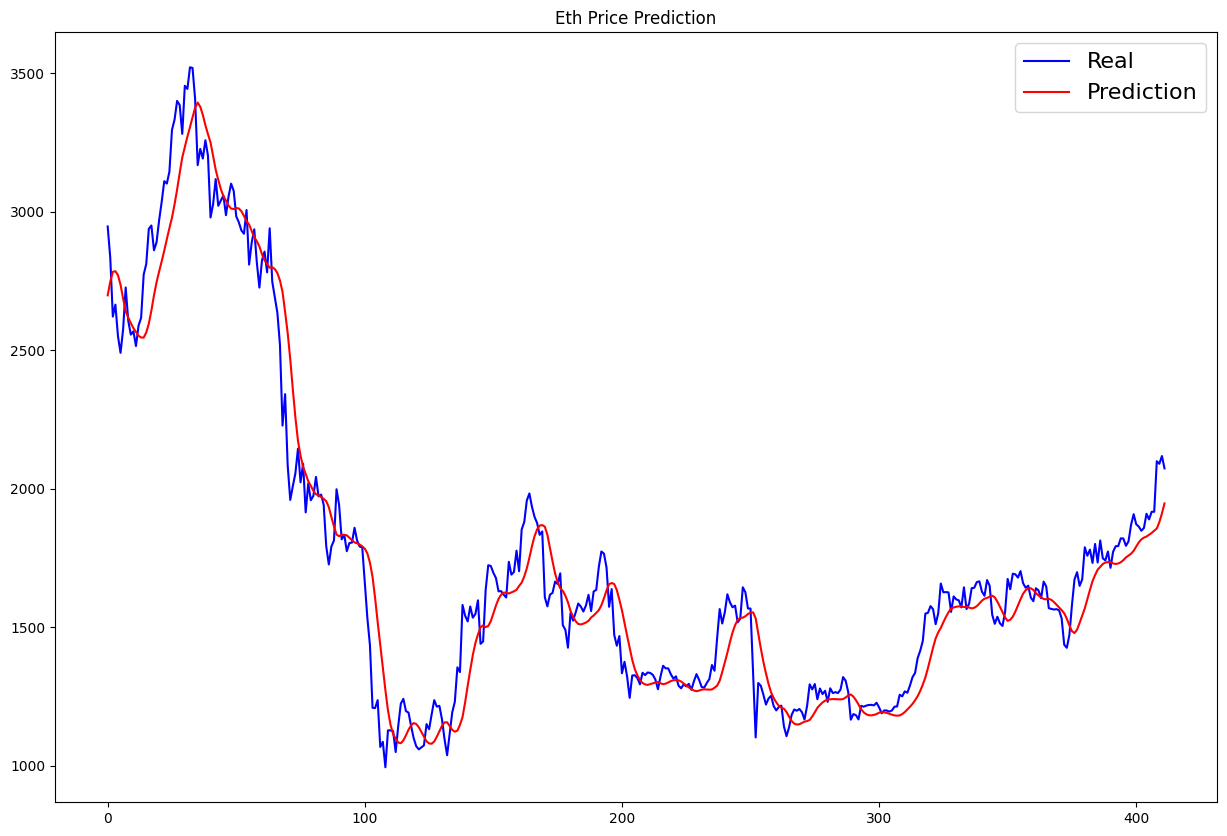

In [103]:
plt.figure(figsize=(15, 10))
plt.plot(y_test_transformed, color='blue', label='Real')
plt.plot(lstm_pred_transformed, color='red', label='Prediction')
plt.title('Eth Price Prediction')
plt.legend(loc='best', fontsize=16)
plt.show()


### XGBoost Model Testing

In [104]:
# Making predictions on test data
xgb_pred = xgb_model.predict(dtest)
# Inverting the scaling of the predictions and test data
xgb_pred_transformed = sc.inverse_transform(xgb_pred.reshape(-1, 1))
y_test_transformed = sc.inverse_transform(y_test)


In [105]:
# Calculating the mean squared error of the LSTM model
xgb_mse = mean_squared_error(xgb_pred, y_test)
xgb_mae = mean_absolute_error(xgb_pred, y_test)
xgb_rmse = mean_squared_error(xgb_pred, y_test, squared=False)

print('XGBoost Model MSE:', xgb_mse)
print('XGBoost Model MAE:', xgb_mae)
print('XGBoost Model RMSE:', xgb_rmse)


XGBoost Model MSE: 0.0004218476902704535
XGBoost Model MAE: 0.015352940836973547
XGBoost Model RMSE: 0.020538931088799475


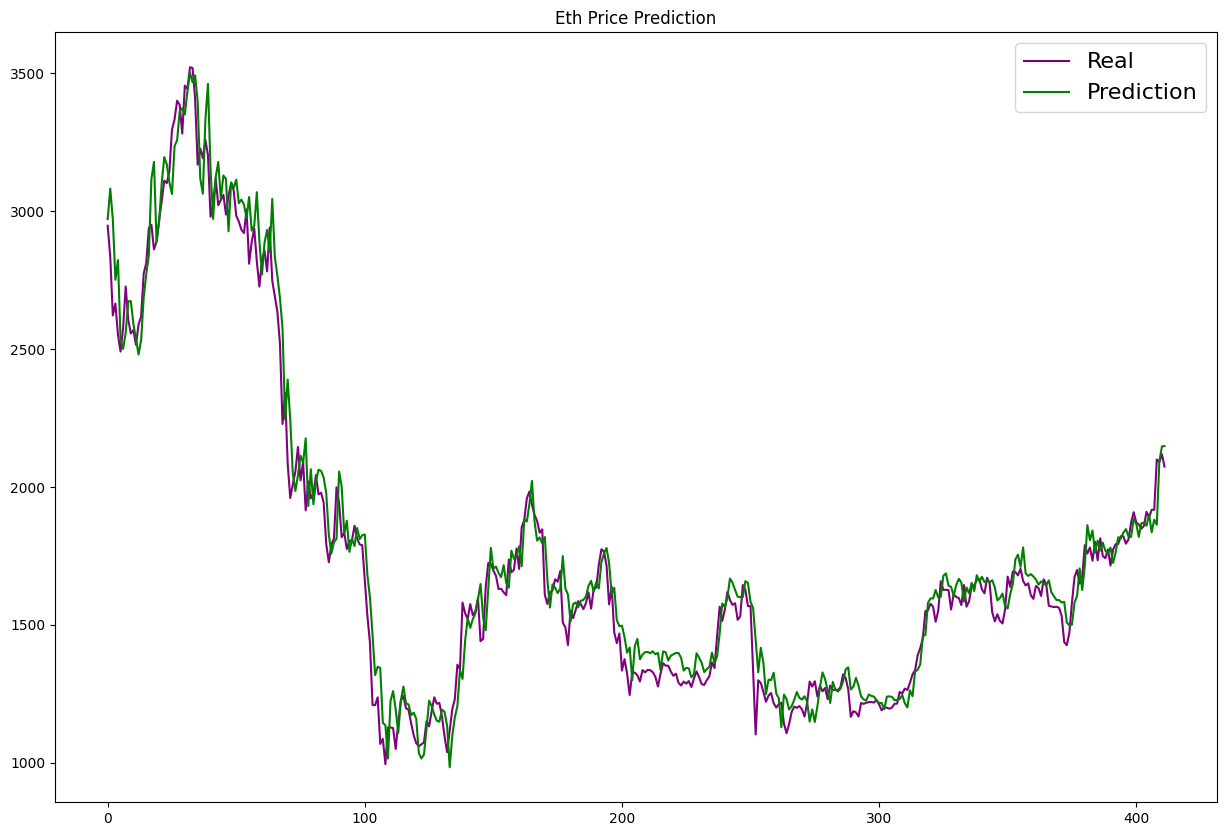

In [106]:
# Plotting the predicted vs. actual prices
plt.figure(figsize=(15, 10))
plt.plot(y_test_transformed, color='purple', label='Real')
plt.plot(xgb_pred_transformed, color='green', label='Prediction')
plt.title('Eth Price Prediction')
plt.legend(loc='best', fontsize=16)
plt.show()


### Random Forest Model Testing


In [107]:
# Making predictions on test data
rf_pred = rf_model.predict(X_test.reshape(X_test.shape[0], -1))
# Inverting the scaling of the predictions and test data
rf_pred_transformed = sc.inverse_transform(rf_pred.reshape(-1, 1))
y_test_transformed = sc.inverse_transform(y_test)

In [108]:
# Calculating the mean squared error of the LSTM model
rf_mse = mean_squared_error(rf_pred, y_test)
rf_mae = mean_absolute_error(rf_pred, y_test)
rf_rmse = mean_squared_error(rf_pred, y_test, squared=False)

print('Random Forest Model MSE:', rf_mse)
print('Random Forest Model MAE:', rf_mae)
print('Random Forest Model RMSE:', rf_rmse)


Random Forest Model MSE: 0.00043639364418259597
Random Forest Model MAE: 0.01569254988330534
Random Forest Model RMSE: 0.020890036959818812


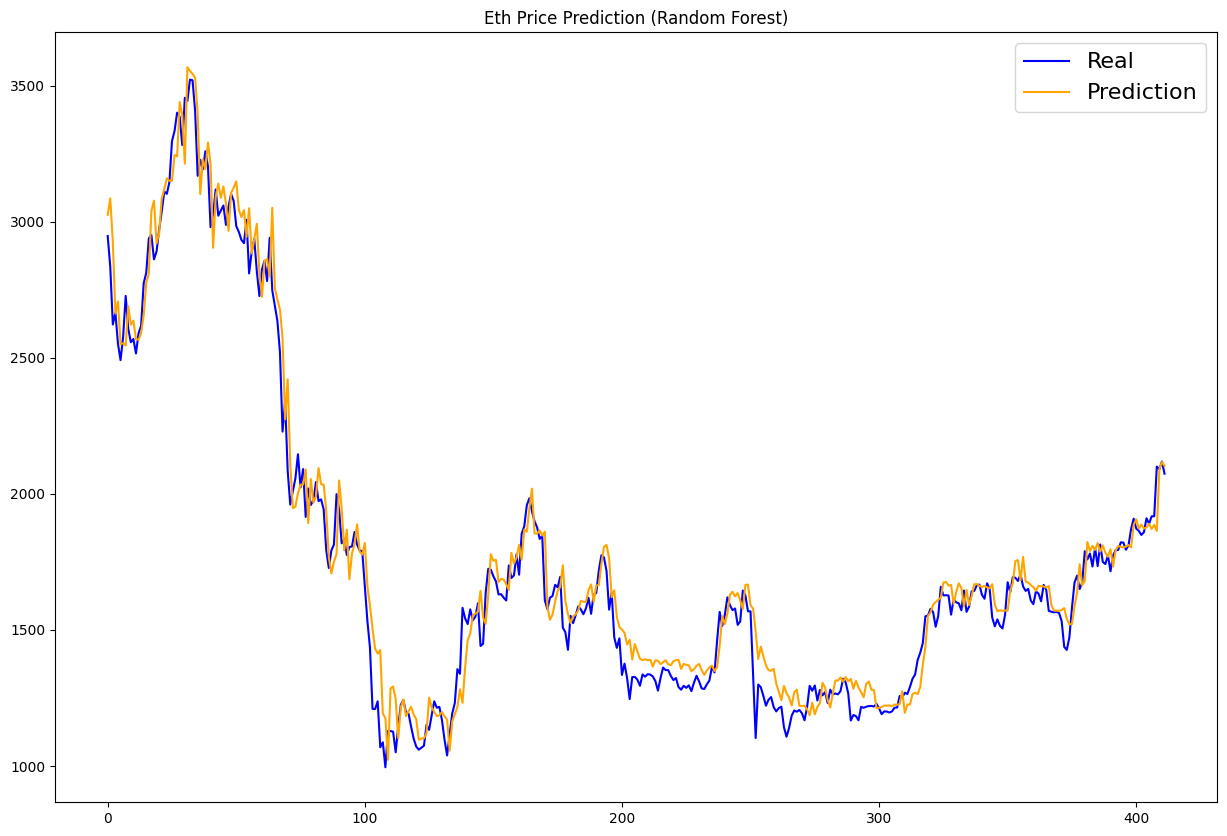

In [109]:
# Plotting the actual vs predicted prices for Random Forest model
plt.figure(figsize=(15, 10))
plt.plot(y_test_transformed, color='Blue', label='Real')
plt.plot(rf_pred_transformed, color='orange', label='Prediction')
plt.title('Eth Price Prediction (Random Forest)')
plt.legend(loc='best', fontsize=16)
plt.show()


### SVR Model Testing

In [110]:
# Making predictions on test data
svr_pred = svr_model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1]))
# Inverting the scaling of the predictions and test data
svr_pred_transformed = sc.inverse_transform(svr_pred.reshape(-1, 1))
y_test_transformed = sc.inverse_transform(y_test)

In [111]:
# Calculating the mean squared error of the LSTM model
svr_mse = mean_squared_error(svr_pred, y_test)
svr_mae = mean_absolute_error(svr_pred, y_test)
svr_rmse = mean_squared_error(svr_pred, y_test, squared=False)

print('SVR Model MSE:', svr_mse)
print('SVR Model MAE:', svr_mae)
print('SVR Model RMSE:', svr_rmse)


SVR Model MSE: 0.0004337785901524045
SVR Model MAE: 0.016467762945042028
SVR Model RMSE: 0.020827351971683884


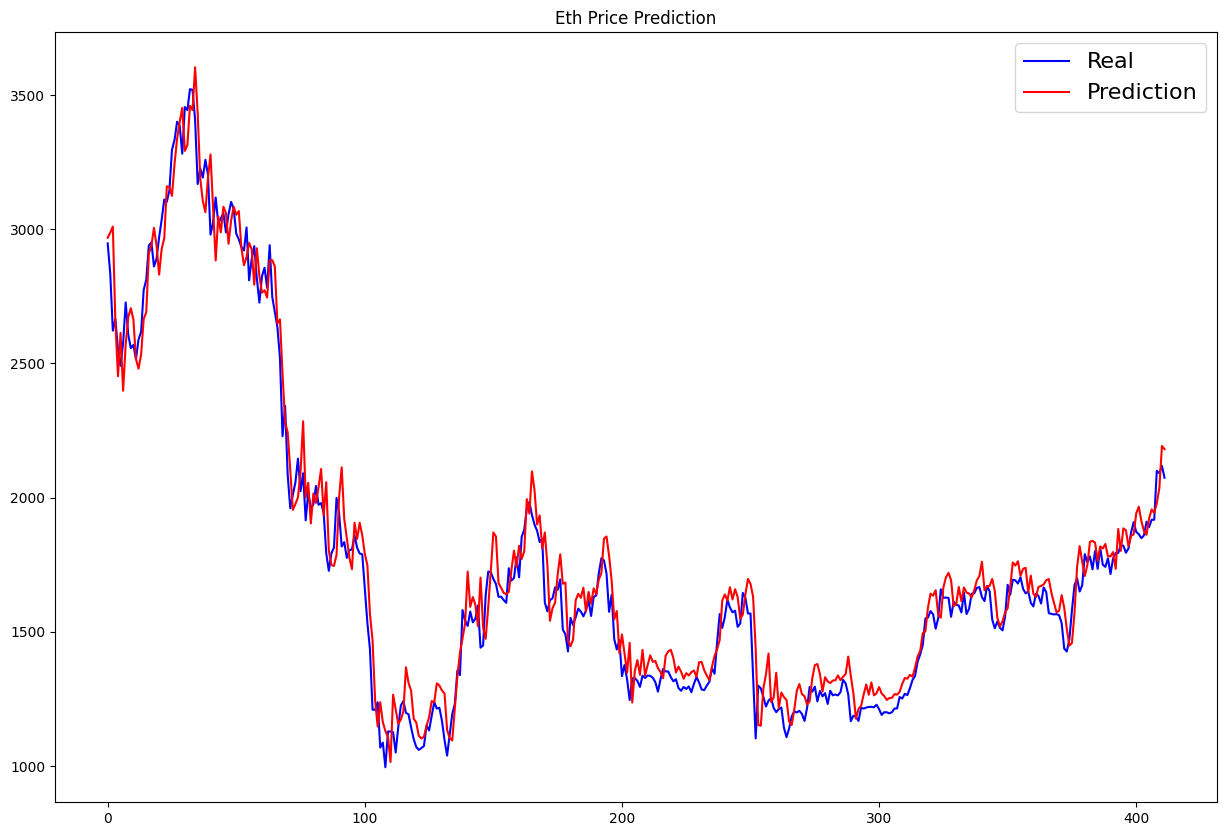

In [112]:
# Plotting the predicted vs. actual prices
plt.figure(figsize=(15, 10))
plt.plot(y_test_transformed, color='blue', label='Real')
plt.plot(svr_pred_transformed, color='red', label='Prediction')
plt.title('Eth Price Prediction')
plt.legend(loc='best', fontsize=16)
plt.show()


# Comparing Models

- Comparing in the final outcome of each model

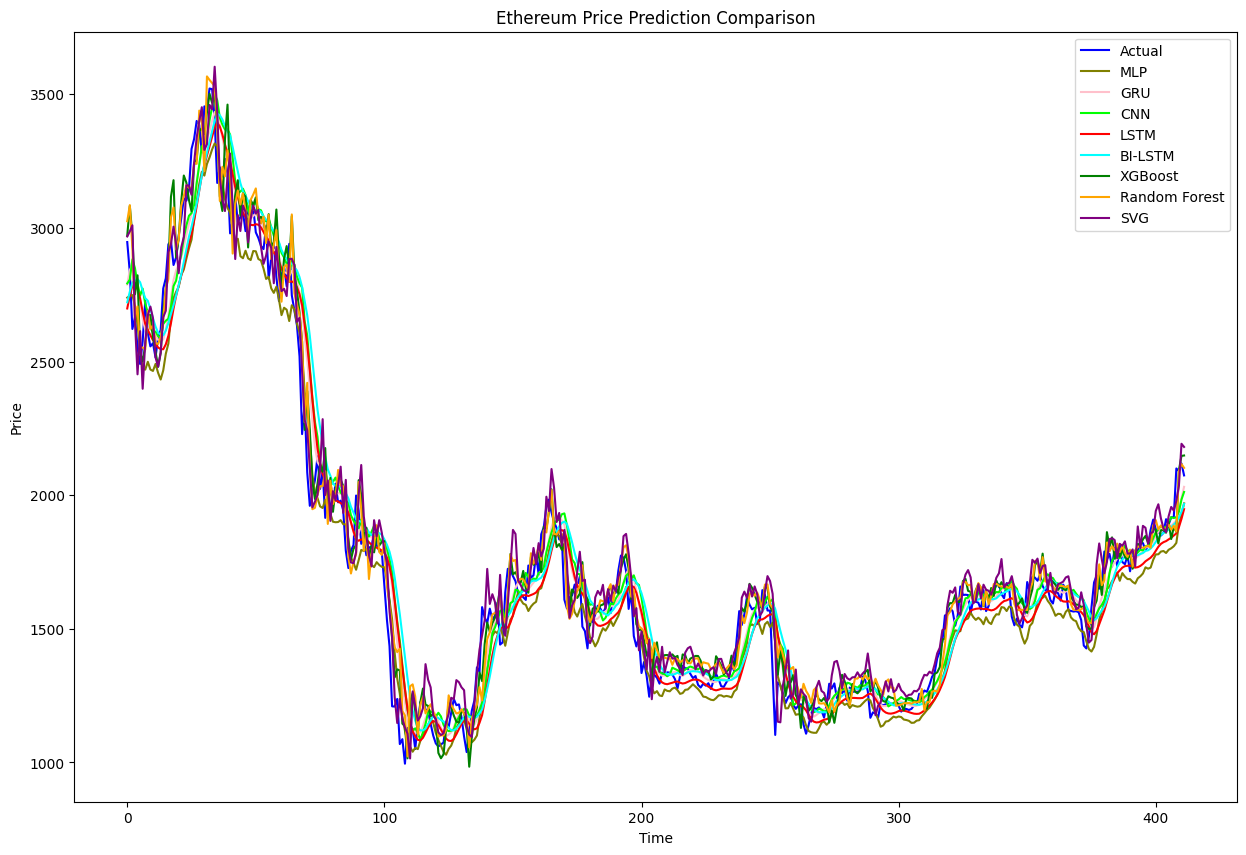

In [123]:
# Plotting the comparison
plt.figure(figsize=(15, 10))
plt.plot(y_test_transformed, color='blue', label='Actual')
plt.plot(mlp_pred_transformed, color='olive', label='MLP')
plt.plot(gru_pred_transformed, color='pink', label='GRU')
plt.plot(cnn_pred_transformed, color='lime', label='CNN')
plt.plot(lstm_pred_transformed, color='red', label='LSTM')
plt.plot(bilstm_pred_transformed, color='cyan', label='BI-LSTM')
plt.plot(xgb_pred_transformed, color='green', label='XGBoost')
plt.plot(rf_pred_transformed, color='orange', label='Random Forest')
plt.plot(svr_pred_transformed, color='purple', label='SVG')
plt.title('Ethereum Price Prediction Comparison')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


- Comparing the model's MSE 

In [129]:
# Print the MSE of each model
print('=========MSE==========')
print('Multilayer Perceptron MSE:', mlp_mse)
print('Gated Recurrent Unit MSE:', gru_mse)
print('Convolutional Neural Network MSE:', cnn_mse)
print('Long short-term memory MSE:', lstm_mse)
print('Bi Long short-term memory MSE:', bilstm_mse)
print('XGBoost Model MSE:', xgb_mse)
print('Random Forest Model MSE:', rf_mse)
print('SVR Model MSE:', svr_mse)
print('=========MAE==========')
print('Multilayer Perceptron MAE:', mlp_mae)
print('Gated Recurrent Unit MAE:', gru_mae)
print('Convolutional Neural Network MAE:', cnn_mae)
print('Long short-term memory MAE:', lstm_mae)
print('Bi Long short-term memory MAE:', bilstm_mae)
print('XGBoost Model MAE:', xgb_mae)
print('Random Forest Model MAE:', rf_mae)
print('SVR Model MAE:', svr_mae)
print('=========RMSE==========')
print('Multilayer Perceptron RMSE:', mlp_rmse)
print('Gated Recurrent Unit RMSE:', gru_rmse)
print('Convolutional Neural Network RMSE:', cnn_rmse)
print('Long short-term memory RMSE:', lstm_rmse)
print('Bi Long short-term memory RMSE:', bilstm_rmse)
print('XGBoost Model RMSE:', xgb_rmse)
print('Random Forest Model RMSE:', rf_rmse)
print('SVR Model RMSE:', svr_rmse)


=========MSE==========
Multilayer Perceptron MSE: 0.0006500998699703938
Gated Recurrent Unit MSE: 0.0005600607069121045
Convolutional Neural Network MSE: 0.0007349888311022533
Long short-term memory MSE: 0.0007881370827928452
Bi Long short-term memory MSE: 0.0009980063750317978
XGBoost Model MSE: 0.0004218476902704535
Random Forest Model MSE: 0.00043639364418259597
SVR Model MSE: 0.0004337785901524045
=========MAE==========
Multilayer Perceptron MAE: 0.02047678372714629
Gated Recurrent Unit MAE: 0.016615089026171384
Convolutional Neural Network MAE: 0.01913151473671763
Long short-term memory MAE: 0.020473051942627708
Bi Long short-term memory MAE: 0.022464854164516372
XGBoost Model MAE: 0.015352940836973547
Random Forest Model MAE: 0.01569254988330534
SVR Model MAE: 0.016467762945042028
=========RMSE==========
Multilayer Perceptron RMSE: 0.025497056103997454
Gated Recurrent Unit RMSE: 0.0236656017652648
Convolutional Neural Network RMSE: 0.027110677437169536
Long short-term memory RMSE

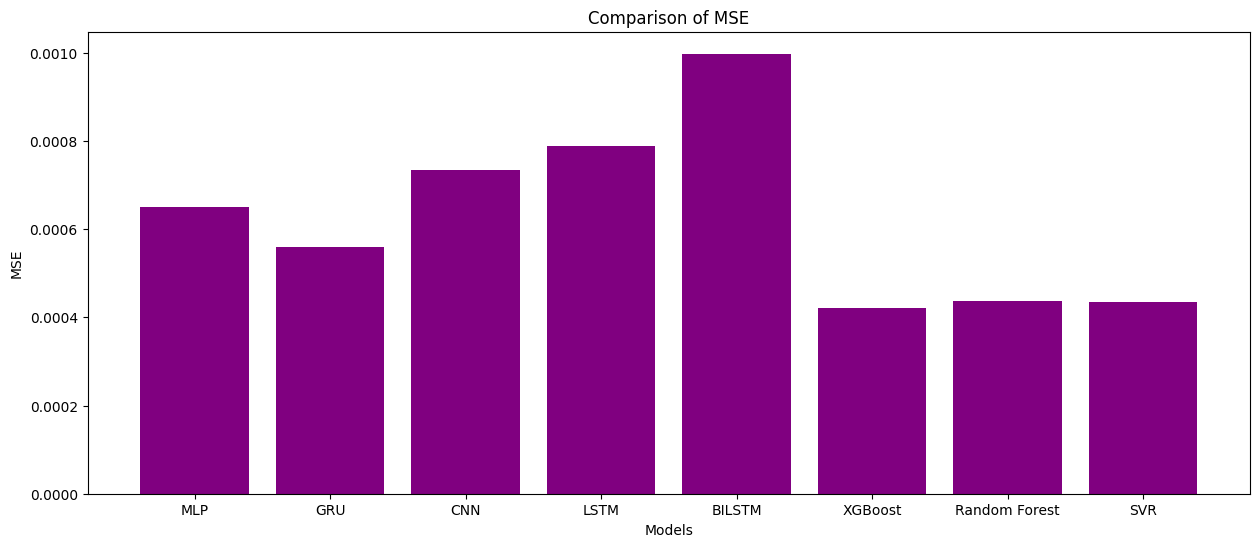

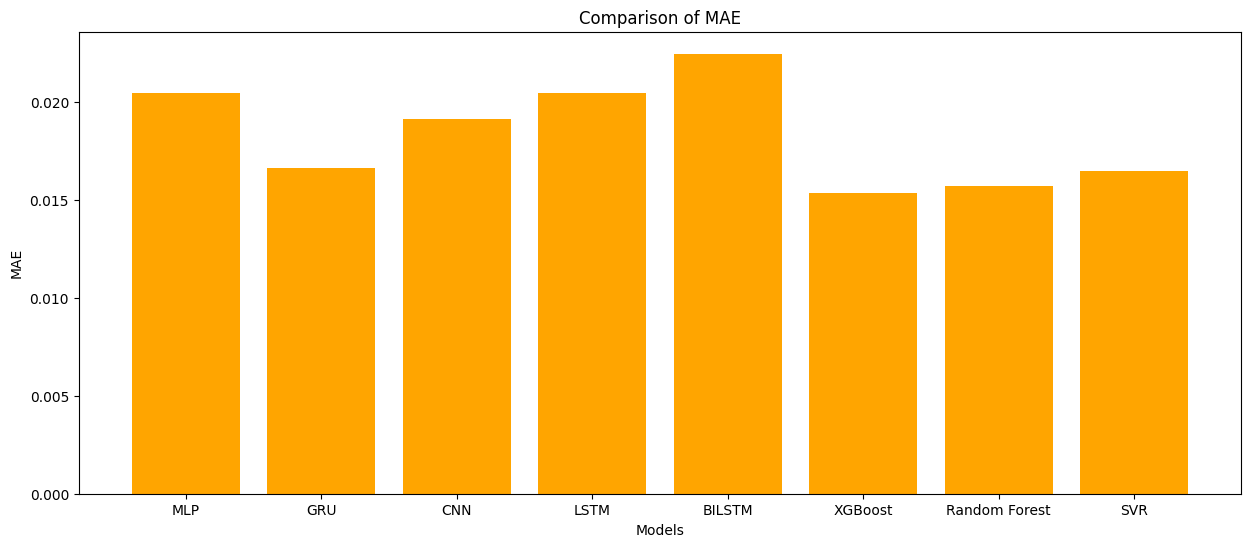

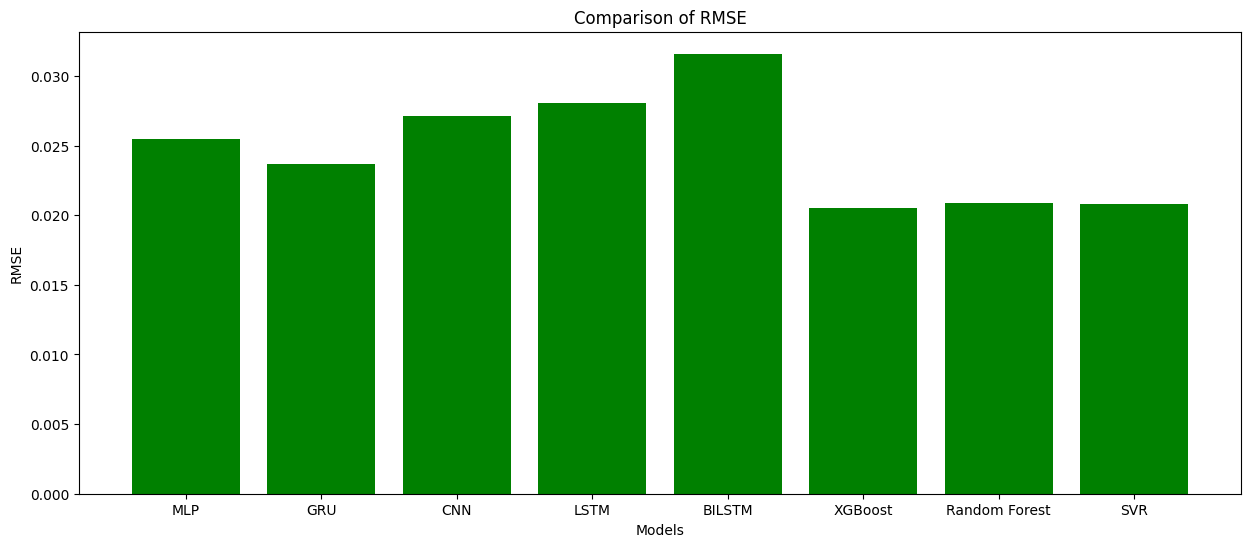

In [130]:
import matplotlib.pyplot as plt

# Set up data
models = ['MLP','GRU','CNN', 'LSTM','BILSTM', 'XGBoost', 'Random Forest', 'SVR']
mse_values = [mlp_mse, gru_mse, cnn_mse,
              lstm_mse, bilstm_mse, xgb_mse, rf_mse, svr_mse]
mae_values = [mlp_mae, gru_mae, cnn_mae, lstm_mae,
              bilstm_mae, xgb_mae, rf_mae, svr_mae]
rmse_values = [mlp_rmse, gru_rmse, cnn_rmse,
               lstm_rmse, bilstm_rmse, xgb_rmse, rf_rmse, svr_rmse]

# Plot comparison of MSE
plt.figure(figsize=(15, 6))
plt.bar(models, mse_values, color = 'purple')
plt.title('Comparison of MSE')
plt.xlabel('Models')
plt.ylabel('MSE')
plt.show()

# Plot comparison of MAE
plt.figure(figsize=(15, 6))
plt.bar(models, mae_values, color='orange')
plt.title('Comparison of MAE')
plt.xlabel('Models')
plt.ylabel('MAE')
plt.show()

# Plot comparison of RMSE
plt.figure(figsize=(15, 6))
plt.bar(models, rmse_values, color='green')
plt.title('Comparison of RMSE')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.show()


